## Script to parse behavioral data from pickle files

The purpose of this notebook is to parse the behavioral data in the appropriate pickle files into a format that is easily usable for analysis and plotting.

The pickle files for each animal contain dictionaries where the keys are session names and the values are lists of trials where every trial is a dictionary of this form:

```            trial = {
                'trial_num': 347,
                'stim_presentation_time': 1134567, # in microseconds
                'behavior_outcome_time': 1734567, # in microseconds
                'reaction_time': 600000, # in microseconds
                'behavior_outcome': 'success', # can be 'success', 'failure' or 'ignore'
                'BlobIdentityIdx': 1, # can be 1 or 2
            }
```

Continue below for how these data will be transformed. Make sure to run these cells in order.

### Dependencies

In [1]:
from __future__ import division
import os
import copy
import math
import random
import scipy.stats as stats
import scipy.integrate as integrate
import numpy as np
import seaborn as sns
import pymworks
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
%matplotlib inline

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')


### Functions  and parameters needed to parse the pickle files

##### Parameters for running parsing

In [2]:
bootstrap_iterations = 100 # choose number of bootstrap iterations for calculating performance error
wiggle_session_indices = False

##### Location of files

In [3]:
# filepaths of data to analyze

filepath1 = '_data/AL_and_AM_Cohorts/newshapes_experiment/6_stimB/180914_to_181004/pickle_files_by_session/'
filepath2 = '_data/AL_and_AM_Cohorts/newshapes_experiment/6_baselinefullcross/180825_to_180913/pickle_files_by_session/'

##### Defining functions

**Logic:**

Function ```open_pickle_files_and_analyze()``` takes in the ```filepath``` as input, finds the pickle files, and then runs the function ```get_data```

Function ```get_data()``` takes in ```animal_name``` and ```trials_grouped_by_session``` as input, and then outputs a dictionary with the parsed data of the following form:

``` data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    } 
```

where:

- ***animal_name*** : animal name  
- **rt_by_trial** : list of individual trial reaction times across all sessions in pickle file
- **outcome_by_trial** : list of individual trial outcomes ('success', 'failure') across all sessions in pickle file
- **iti_by_trial** : list of individual trial intertrial intervals across all sessions in pickle file

- **beh_outcome_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure')
- **rt_by_session** : dict where key = session, val = individual trial reaction times
- **rt_success_by_session** : dict where key = session, val = individual success trial reaction times
- **rt_failure_by_session** : dict where key = session, val = individual failure trial reaction times
- **iti_by_session** : dict where key = session, val = individual trial intertrial intervals

- **pct_correct_by_session** : dict where key = session, val = accuracy for that session
- **bootstrap_error_by_session** : dict where key = session, val = bootstrapped accuracy error for that session
    
- **avg_rt_success_by_session** : dict where key = session, val = avg RT for success trials in that session
- **avg_rt_failure_by_session** : dict where key = session, val = avg RT for failure trials in that session
- **rt_success_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session
- **rt_failure_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session

- **norm_session_indices** : list of indices for sessions normalized from 0 to 1 (if animal takes 10 sessions to learn, then list contains [0.1, 0.2, 0.3,...,1.0]

the user can then use this data as she/he/they pleases. Some examples in the cells below.

In [4]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)
        
        animal = data.keys()[0]# get animal name

        # notify the user of the sessions that are read
        print ' '
        print 'Read data from', animal, 'for...'
        print 'sessions:'
        for session in sorted(data[animal].keys()):
            print session

        # lump sessions from all phases into one dictionary
        trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session) # analyze one animal at a time
        # store data in dictionaries
        results_by_session[animal] = result_by_session # add to results_by_session dictionary
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys() # add sessions to sessions_by_animal dictionary

    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    stim_id_by_trial = data_by_trial['stim_id_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    iti_success_by_session = data_by_session['iti_success_by_session']
    iti_failure_by_session = data_by_session['iti_failure_by_session']
    stim_id_by_session = data_by_session['stim_id_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_bootstrap_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_bootstrap_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_bootstrap_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    pct_correct_bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    hitrate_falsealarms_by_session = hitrate_falsealarms(beh_outcome_by_session, stim_id_by_session)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'pct_correct_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'hitrate_falsealarms_by_session': hitrate_falsealarms_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_bootstrap_error_by_session': rt_success_bootstrap_error_by_session,
    'rt_failure_bootstrap_error_by_session': rt_failure_bootstrap_error_by_session,
    'rt_bootstrap_error_by_session': rt_bootstrap_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data

# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    outcome = []
    iti = []
    stim_id = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                # append stimulus identity
                stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                    iti.append(inter_trial_interval)
                    
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome'] == 'ignore':
                pass 
          
    data_by_trial = {
    'rt_by_trial': rt,
    'outcome_by_trial': outcome,
    'iti_by_trial': iti,
    'stim_id_by_trial': stim_id
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    rt_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    iti_success_by_session = {}
    iti_failure_by_session = {}
    stim_id_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_behavior_outcome = []
        session_stim_id = []
        session_iti = []
        session_success_iti = []
        session_failure_iti = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # WITHOUT IGNORES
                session_rt.append(trials[trial_index]['reaction_time'])
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome'])
                session_stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
                    
            # intertrial interval analysis
            if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                session_iti.append(iti_for_first_trial)
            elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                next_stim_time = trials[trial_index]['stim_presentation_time']
                response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                session_iti.append(inter_trial_interval)
                
                if trials[trial_index - 1]['behavior_outcome'] == 'success': # create separate list with previous success trial itis
                    session_success_iti.append(inter_trial_interval)
                elif trials[trial_index - 1]['behavior_outcome'] == 'failure': # create separate list with previous failure trial itis
                    session_failure_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        rt_by_session[session] = session_rt
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        iti_success_by_session[session] = session_success_iti
        iti_failure_by_session[session] = session_failure_iti
        stim_id_by_session[session] = session_stim_id
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

def safe_division(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 0
    
def hitrate_falsealarms(beh_out_by_session, stim_id_by_session):
    hitrate_falsealarms_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        stim_ids = stim_id_by_session[session]
        possible_stim_ids = set(stim_ids)
        hitrate_falsealarms = dict.fromkeys(possible_stim_ids, 0)
        for stim_id in possible_stim_ids:
            hits = 0
            falsealarms = 0
            total_signal_stim = 0
            total_noise_stim = 0
            for trial in range(len(stim_id_by_session[session])):
                if stim_id_by_session[session][trial] == stim_id:
                    total_signal_stim += 1
                    if beh_out_by_session[session][trial] == 'success':
                        hits += 1
                elif stim_id_by_session[session][trial] != stim_id:
                    total_noise_stim += 1
                    if beh_out_by_session[session][trial] == 'failure':
                        falsealarms += 1
            hitrate_falsealarms[stim_id] = {
                'hits_signal_stim': hits,
                'total_signal_stim': total_signal_stim,
                'falsealarms_noise_stim': falsealarms,
                'total_noise_stim': total_noise_stim,
                'hit_rate_signal_stim': safe_division(hits, total_signal_stim),
                'falsealarm_rate_noise_stim': safe_division(falsealarms, total_noise_stim)}
        hitrate_falsealarms_by_session[session] = hitrate_falsealarms
    return hitrate_falsealarms_by_session
                    

# ~~~~~~~~~~ Get relevant data ~~~~~~~~~~

def get_relevant_data(all_data_dict, relevant_data, all_sessions = True, sessions_to_count = 99, sessions_from_start = False):
    '''
    function that creates smaller dictionaries where animals are keys and values are lists of all data by session, or collapsed to one list
    
    input:
    all_data_dict:       dictionary outputted by open_pickle_files_and_analyze()
    relevant_data:       key for values in all_data_dict (string)
                           NOTE: this key should be for data organized by session, not by trial!
    all_sessions:        boolean var determining whether all sessions are included (True) or not (False)
                           if False, need to determine sessions_to_count, and sessions_from_start
    sessions_to_count:   number of sessions to count (i.e. 10 if want 10 sessions)
    sessions_from_start: boolean var determining whether sessions are counted from beginning of sorted list (True) or end (False)
                           e.g. if want only last 10 sessions, then: 
                           sessions_to_count = 10, sessions_from_start = False
    
    output:
    relevant_data_dict:  dictionary where key = animal, value = list of data from relevant_data key
                           where every list entry is from one session and sessions have been sorted
                           in the case of averages, such as "avg_rt_by_session", each list entry is a number
                           in the case of lists, such as "rt_by_session", each list entry is a list              
    '''
    relevant_data_dict = {}
    for animal in all_data_dict.iterkeys():
        if all_sessions == True:
            for session in sorted(all_data_dict[animal][relevant_data].keys()):
                try:
                    relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                except KeyError:
                    relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
        elif all_sessions == False:
            if sessions_from_start == True:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[:sessions_to_count]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
            elif sessions_from_start == False:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[-sessions_to_count:]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
    return relevant_data_dict

# ~~~~~~~~~~ Prepare inter-trial intervals ~~~~~~~~~~

def adjust_itis(iti_data, min_Drsi):
    '''
    adjust itis by subtracting minimum Drsi (Derr or Dcorr depending on type of iti) function
    '''
    iti_data_adj = {}
    for animal in iti_data.keys():
        for session in iti_data[animal]:
            try:
                iti_data_adj[animal].append([i - min_Drsi for i in session])
            except KeyError:
                iti_data_adj[animal] = [[i - min_Drsi for i in session]]
    return iti_data_adj

def avg_adjusted_itis(iti_data_adj, boundary = 2000):
    '''
    take mean of itis for all values under the boundary (don't count itis beyond the boundary') function
    '''
    iti_data_adj_mean = {}
    iti_data_adj_sem = {}
    iti_data_adj_median = {}
    for animal in iti_data_adj.keys():
        for session in iti_data_adj[animal]:
            session_below_boundary = [i for i in session if i < boundary]
            try:
                iti_data_adj_mean[animal].append(np.nanmean(session_below_boundary))
                iti_data_adj_median[animal].append(np.nanmedian(session_below_boundary))
                # regular sem
#                 iti_data_adj_sem[animal].append(stats.sem([i for i in session if i < boundary]))
            except KeyError:
                iti_data_adj_mean[animal] = [np.nanmean(session_below_boundary)]
                iti_data_adj_median[animal] = [np.nanmedian(session_below_boundary)]
#                 iti_data_adj_sem[animal] = [stats.sem([i for i in session if i < boundary])]

            # calculate bootstrap sem
            if len(session_below_boundary) > 0:
                list_of_avg = []
                for i in xrange(bootstrap_iterations):
                    r = np.random.choice(session_below_boundary, len(session_below_boundary))
                    avg = np.mean(r)
                    list_of_avg.append(avg)
                mean_error = np.std(list_of_avg)
                try:
                    iti_data_adj_sem[animal].append(mean_error)
                except KeyError:
                    iti_data_adj_sem[animal] = [mean_error]
            else:
                try:
                    iti_data_adj_sem[animal].append(float('nan'))
                except KeyError:
                    iti_data_adj_sem[animal] = [float('nan')]
    return iti_data_adj_mean, iti_data_adj_sem, iti_data_adj_median

# ~~~~~~~~~~ Convert reaction times to mean normalized decision times ~~~~~~~~~~

def convert_RTs_to_DTs(rts, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dts = {}
    for animal in rts.keys():
        if with_itis == True:
            for sesh in range(len(rts[animal])):
                try:
                    dts[animal].append((rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh]))
                except KeyError:
                    dts[animal] = [(rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh])]
        elif with_itis == False:
            dts[animal] = [(i - t0)/(t0 + derr) for i in rts[animal]]
    return dts

def calc_DT_err(rt_err, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dt_err = {}
    for animal in rt_err.keys():
        if with_itis == True:
            for sesh in range(len(rt_err[animal])):
                sum_sqrd_err = math.sqrt(rt_err[animal][sesh]**2 + iti_err[animal][sesh]**2)
                adj_err = sum_sqrd_err / (t0 + derr + iti_err[animal][sesh])
                try:
                    dt_err[animal].append(adj_err)
                except KeyError:
                    dt_err[animal] = [adj_err]
        elif with_itis == False:
            dt_err[animal] = [i/(t0 + derr) for i in rt_err[animal]]
        
    return dt_err

# ~~~~~~~~~~ Mesh data to create averages over learning ~~~~~~~~~~

def mesh_data(results, datakey = 'none'):
    '''
    input:
        results = dict where keys = animals, values = either dictionary with data or a list with data
        datakey = if not 'none', keys to dictionary with data
                  if none - values of results are lists
                  
    output:
        meshed_data = dict containing meshed data and meshed indices
    '''
    
    d = {}
    for animal in results.keys():
#         i = results[animal]['norm_session_indices'] # indexed session list comes pre-made from get_data_for_figure()
        if datakey == 'none':
            i = [(x+1)/len(results[animal]) for x in range(len(results[animal]))]
            y_data = results[animal]
        elif datakey != 'none':
            i = [(x+1)/len(results[animal][datakey]) for x in range(len(results[animal][datakey]))]
            y_data = results[animal][datakey]
        
        y = []
        
        if type(y_data) == dict:
            for session in sorted(y_data.iterkeys()):
                y.append(y_data[session])
            d[animal] = {'i': i, 'y': y}
        elif type(y_data) == list:
            y = y_data
            d[animal] = {'i': i, 'y': y}

    all_y = []
    all_i = []
    for a in d.iterkeys():
        # print 'key = ' + a
        if len(all_i) == 0:
            # print 'in if statement'
            all_i = d[a]['i']
            all_y = d[a]['y']
            # print all_i
            # print all_x
        else:
            # print 'in else statement'
            for j in range(len(d[a]['i'])):
                # print 'first for loop'
                for i in range(len(all_i)):
                    # print 'second for loop'
                    if all_i[i] >= d[a]['i'][j]:
                        #print 'first half'
                        #print all_x[:i]
                        all_i = all_i[:i] + [d[a]['i'][j]] + all_i[i:]
                        all_y = all_y[:i] + [d[a]['y'][j]] + all_y[i:]
                        # print all_i
                        # print all_x
                        break

    # print 'all_x:', all_x
    # print ' '
    # print 'all_i:', all_i

    meshed_data = {'all_i': all_i, 'all_y': all_y}

    return meshed_data

def avg_binned_data(meshed_data, n_bins):
    x_data = meshed_data['all_i']
    y_data = meshed_data['all_y']

    # if every animal has the exact number of sessions, add some noise to the indices to shuffle them:
    if wiggle_session_indices == True:
        x_data = [(i+(random.uniform(-1,1)/25)) for i in x_data]
    else:
        pass


    n_bins = n_bins
    
    x_n, x_bins, x_patches = plt.hist(x_data, bins = n_bins)

    # based on the bins for x_data, bin y_data
    # note that this code creates an extra bin at the end because there is one more bin value than bins
    # that is fixed with a for loop below
    y_bins = []
    for i in range(len(x_bins)):
        y_bin = []
        for j in range(len(x_data)):
            if i < (len(x_bins)-1):
                if (x_data[j] >= x_bins[i] and (x_data[j] < x_bins[i+1])):
                    y_bin.append(y_data[j])
                else:
                    pass
            elif i >= (len(x_bins)-1):
                if x_data[j] == (x_bins[i]):
                    y_bin.append(y_data[j])
                else:
                    pass
        y_bins.append(y_bin)

    # the above code creates an extra bin at the end
    # this for loop combines the last two bins
    for i in range(len(y_bins)):
        if i == (len(y_bins)-1):
            y_bins[i-1] = y_bins[i-1] + y_bins[i]
            y_bins.pop(i)
        else:
            pass

    # calculate the mean for values in every bin
    y_bins_mean = []
    y_bins_std = []
    y_bins_sem = []
    y_bins_median = []
    y_bins_25percentile = []
    y_bins_75percentile = []
    for i in y_bins:
#         if 0 in i:
#             i = [0.001 if x == 0 else x for x in i] # if there are zeroes, convert to small values to not have issues with averaging
#         else:
#             pass
        y_bins_mean.append(np.nanmean(i))
        y_bins_median.append(np.nanmedian(i))
        y_bins_25percentile.append(np.nanmedian(i) - np.nanpercentile(i, q = 25))
        y_bins_75percentile.append(np.nanpercentile(i, q = 75) - np.nanmedian(i))
        y_bins_std.append(np.nanstd(i))
        y_bins_sem.append(np.nanstd(i)/math.sqrt(len(i)))

    # calculate bin centers in order to plot the mean
    x_bincenters = [np.mean([x_bins[i],x_bins[i+1]]) for i in range(len(x_bins)-1)]

#     # Plot
#     xmin = -0.05 # indexed sessions from 0 to 1
#     xmax = 1.05
#     ymin = 0.4 # performance from 0 to 1
#     ymax = 1.0

#     fig = plt.figure()
#     plt.plot(x_data, y_data, 'r.', markersize=10, label=u'observations')
#     plt.errorbar(x_bincenters, y_bins_mean, yerr = y_bins_sem, fmt = 'bo-', label=u'binned average')
#     plt.xlabel('normalized session time')
#     plt.ylabel('mean performance $\pm$ sem')
#     plt.axis([xmin, xmax, ymin, ymax])
#     plt.legend(loc='lower right')
#     plt.savefig('AK_Cohort_perf_binned_avg.pdf')
#     plt.close()
#     # plt.show()

    avg_binned_data = {
    'x_bins': x_bins,
    'x_bincenters': x_bincenters,
    'y_bins': y_bins,
    'y_bins_mean': y_bins_mean,
    'y_bins_std': y_bins_std,
    'y_bins_sem': y_bins_sem,
    'y_bins_median': y_bins_median,
    'y_bins_25percentile': y_bins_25percentile,
    'y_bins_75percentile': y_bins_75percentile
    }

    return avg_binned_data

# ~~~~~~~~~~ calculate OPC curve ~~~~~~~~~~

def calculate_opc():
    #this function returns a dictionary with two arrays with which to plot an optimal performance curve (OPC)

    #eta = (A/sigma)^2 (signal to noise ratio (drift rate to noise))
    #theta = | threshold / A | (ratio of threshold over drift rate)
    
    #make arrays with all possible values for eta and theta
    etas = np.arange(0.0001, 4, 0.01)
    thetas = np.arange(0.0001, 2.5, 0.01)
    e, th = np.meshgrid(etas, thetas)
    #calculate possible error rates with etas and thetas
    #pre-calculate 2*etas to reduce clutter and make equation legible
    e_x_2 = np.multiply(2,e)
    p_err = (1/(1 + np.exp(e_x_2*th)))
    #p_err is a huge array of arrays, but we only need the last array
    ind = len(p_err) - 1
    p_err = p_err[ind]
    #calculate mean normalized decision time as a function of p_err
    #pre-calculate components of equation to reduce clutter and make equation legible
    term1 = 1 / np.multiply(p_err, np.log((1-p_err)/p_err))
    term2 = 1 / (1 - np.multiply(2, p_err))
    mean_norm_dt = 1 / (term1 + term2)

    return {'p_err': p_err, 'mean_norm_dt': mean_norm_dt}

# ~~~~~~~~~~ plot data in OPC space ~~~~~~~~~~

# use when inputs are dictionaries with animals as keys
def opc_during_learning(perf, perf_err, dt, dt_err, filename = '%s_opc_during_learning.pdf'):

    error_rate = {}
    error_rate_err = {}
    mean_norm_dt = {}
    mean_norm_dt_err = {}
    for animal in perf.keys():
        error_rate[animal] = [1 - i for i in perf[animal]]
        error_rate_err[animal] = perf_err[animal]
        mean_norm_dt[animal] = dt[animal]
        mean_norm_dt_err[animal] = dt_err[animal]

        opc = calculate_opc()
        x_opc = opc['p_err']
        y_opc = opc['mean_norm_dt']

        x = error_rate[animal]
        y = mean_norm_dt[animal]
        xerr = error_rate_err[animal]
        yerr = mean_norm_dt_err[animal]

        xmin = 0.0
        xmax = 0.55
        ymin = 0.0
        ymax = 0.5

        c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

        plt.close()
        plt.plot(x_opc, y_opc, label = 'opc')
        plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
        plt.axis([xmin, xmax, ymin, ymax])
        plt.xlabel('error rate $\pm$ sem')
        plt.ylabel('mean normalized DT $\pm$ sem')
        plt.title('%s learning trajectory' %animal)
        plt.savefig(filename %animal)
    
       
# use with meshed data or individual animal data to only make one plot during learning
def opc_during_learning_from_list(perf, perf_err, dt, dt_err, listname = 'X Rats', filename = '_opc_during_learning.pdf'):

    error_rate = [1 - i for i in perf]
    error_rate_err = perf_err
    mean_norm_dt = dt
    mean_norm_dt_err = dt_err

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.525
    ymin = 0.0
    ymax = 0.35

    c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + ' learning trajectory')
    plt.savefig(filename)
    
# color code points by frac max rr
def opc_avg_colored_by_frac_max_rr(perf, perf_err, dt, dt_err, pct_max_rr, listname = 'X Rats', filename = '_opc_avg_across_sessions.pdf'):

    error_rate = []
    error_rate_err = []
    mean_norm_dt = []
    mean_norm_dt_err = []
    frac_max_rr = []
    for animal in perf.keys():
        error_rate.append(1 - perf[animal])
        error_rate_err.append(perf_err[animal])
        mean_norm_dt.append(dt[animal])
        mean_norm_dt_err.append(dt_err[animal])
        frac_max_rr.append(pct_max_rr[animal])

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.5
    ymin = 0.0
    ymax = 0.55

    cmin = 0.90
    cmax = 1.0
    crange = cmax - cmin
    
    scaled_frac_max_rr = [(i - cmin)/crange for i in frac_max_rr] # rescale frac_max_rr to give color
#     cmap = plt.cm.Purples
    c = plt.cm.viridis(scaled_frac_max_rr)

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + 'average across sessions by frac max RR')
    plt.savefig(filename)

# ~~~~~~~~~~ calculate percent max reward rate ~~~~~~~~~~


# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr(rt, perf, t0):
    '''
    rt = reaction time, **must be in seconds**
    ER = error rate, 1 - performance
    '''
    
    Dcorr = 6.370 # correct trial ITI in s
    Derr = -3.234 # additional penalty time (can be negative) in s
#     T0 = 0.200 # non-decision time in s
    T0 = t0 # determine t0 from outside function
    
    Dtot = Dcorr + T0 + Derr # mean iti for error trials, including non-decision time
    
    # DT = Dtot*0.45 ## NEED TO FIGURE THIS OUT
    DT = rt - T0
    # ER = 0.1 # measured error rate
    ER = 1 - perf
    
    if perf <= 0.5:
        ER = 1 - 0.501
    else:
        ER = 1 - perf
    
    RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
    
    Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    
    # now compute the optimal reward rate given this SNR
    
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    RRoptimal = np.max(RRs)
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return fraction_max_rr

# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr_iti(rt, perf, t0 = 0.350, dcorr = 6.370, derr = 3.136, corr_iti = 0, err_iti = 0, with_itis = False):
    '''
    **all times must be in seconds**
    rt = reaction time
    ER = error rate, 1 - performance
    
    dcorr = experimental response-to-stimulus interval for previous correct trial
    derr = experimental response-to-stimulus interval for previous error trial
    corr_iti = extra voluntary ITI for a previous correct trial
    err_iti = extra voluntary ITI for a previous error trial
    with_itis = 
    
    '''
    
    # calculate DT and ER
    T0 = t0 # determine t0 from outside function
    DT = rt - T0
    ER = 1 - perf
    
#     if perf <= 0.5:
#         ER = 1 - 0.501
#     else:
#         ER = 1 - perf
    
    # calculate Dcorr, Derr
    if with_itis == True:
        Dcorr = dcorr + corr_iti # success time without iti or 300 ms blocking time, in seconds
        Derr = derr + err_iti # penalty time without iti or 300 ms blocking time, in seconds
        Derr_tilde = Derr - Dcorr # additional penalty time (negative when penalty time lesser than reward time) relative to Dcorr, in seconds
    elif with_itis == False:
        Dcorr = dcorr # correct trial ITI in s
        Derr = derr # additional penalty time (can be negative) in s
        Derr_tilde = Derr - Dcorr
    
    # calculate SNR (Abar) and possible ERs and DTs for that SNR
    
    if ER <= 0.5:
        Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    elif ER > 0.5:
        Abar = -(1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # make SNR negative
#         A_bar = 0 # make it zero when ER is negative 
#     Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    
    # calculate actual RR and possible RRs for that SNR
    if with_itis == True:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr)
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        # calculate RRs with extra voluntary ITIs
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr_tilde) for i,j in zip(ERs, DTs)]
        # calculate RRs without extra voluntary ITIs
        RRs = [(1 - i)/(j + (1 - i)*dcorr + T0 + i*(derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + dcorr + T0 + i*(derr - dcorr)) for i,j in zip(ERs, DTs)]
        
        
    elif with_itis == False:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        RRs = [(1 - i)/(j + (1 - i)*Dcorr + T0 + i*(Derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    
    # now compute the optimal reward rate given this SNR
    RRoptimal = np.max(RRs)
    RRoptimal_ind = np.argmax(RRs) # index of max RR
    
    ERoptimal = ERs[RRoptimal_ind] # use index of max RR to get optimal ER given Abar (SNR)
    PERFoptimal = 1 - ERoptimal
    
    DToptimal = DTs[RRoptimal_ind] # use index of max RR to get optimal DT given Abar (SNR)
    DToptimal_norm = DToptimal / (T0 + Derr)
    RToptimal = DToptimal + T0
    
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return {'fraction_max_rr': fraction_max_rr,
            'opportunity_cost': opportunity_cost,
            'Abar': Abar,
            'ERs': ERs,
            'DTs': DTs,
            'RRs': RRs,
            'RRactual': RRactual,
            'RRoptimal': RRoptimal,
            'ERoptimal': ERoptimal,
            'PERFoptimal': PERFoptimal,
            'DToptimal': DToptimal,
            'RToptimal': RToptimal}

# average reaction times by quantiles
# for one subject at a time
# after vincentizing the subjects may be averaged

def vincentize_RTs(data, bins = 10):

    # sort data 
    data_sorted = sorted(data)

    # determine number of trials per bin
    n_per_bin = len(data)/bins
    n_per_bin = int(math.floor(n_per_bin))

    # perform Vincent averaging (vincentize) on RTs and ERs
    vin_RTs = []
    vin_RTs_sem = []
    bin_sizes = []
    bin_edges_RTs = []
    for current_bin in range(1,(bins+1)):
#         print 'current_bin =', current_bin
        if current_bin == 1:
#             print '  var:', var[0:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[0:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[0:current_bin*n_per_bin])/math.sqrt(len(data_sorted[0:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[0:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[0])
        elif 1 < current_bin < bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[(current_bin-1)*n_per_bin])
        elif current_bin == bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:-1]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:]))
            bin_edges_RTs.append(data_sorted[-1])

    return {'vin_RTs': vin_RTs,
            'vin_RTs_sem': vin_RTs_sem,
            'bin_sizes': bin_sizes,
            'bin_edges_RTs': bin_edges_RTs}

### Run the parsing

Below, the ```results``` dictionary will hold all the results for all the animals present in the pickle files in ```filepath```.

Run the cell below to populate ```results```.

In [5]:
results_stimB = open_pickle_files_and_analyze(filepath1)

 
Read data from AL13 for...
sessions:
AL13_180914stimB.mwk
AL13_180915stimB.mwk
AL13_180916stimB.mwk
AL13_180917stimB.mwk
AL13_180918stimB.mwk
AL13_180919stimB.mwk
AL13_180920stimB.mwk
AL13_180921stimB.mwk
AL13_180925stimB.mwk
AL13_180926stimB.mwk
AL13_180927stimB.mwk
AL13_181002stimB.mwk
AL13_181003stimB.mwk
AL13_181004stimB.mwk
 
Read data from AL14 for...
sessions:
AL14_180914stimB.mwk
AL14_180915stimB.mwk
AL14_180916stimB.mwk
AL14_180917stimB.mwk
AL14_180918stimB.mwk
AL14_180919stimB.mwk
AL14_180920stimB.mwk
AL14_180921stimB.mwk
AL14_180925stimB.mwk
AL14_180926stimB.mwk
AL14_180927stimB.mwk
AL14_181002stimB.mwk
AL14_181003stimB.mwk
AL14_181004stimB.mwk
 
Read data from AL15 for...
sessions:
AL15_180914stimB.mwk
AL15_180915stimB.mwk
AL15_180916stimB.mwk
AL15_180917stimB.mwk
AL15_180918stimB.mwk
AL15_180919stimB.mwk
AL15_180920stimB.mwk
AL15_180921stimB.mwk
AL15_180925stimB.mwk
AL15_180926stimB.mwk
AL15_180927stimB.mwk
AL15_181002stimB.mwk
AL15_181003stimB.mwk
AL15_181004stimB.mwk
 

In [6]:
results_stimB_base = open_pickle_files_and_analyze(filepath2)

 
Read data from AL13 for...
sessions:
AL13_180825.mwk
AL13_180826.mwk
AL13_180827.mwk
AL13_180828.mwk
AL13_180829.mwk
AL13_180830.mwk
AL13_180831.mwk
AL13_180912.mwk
AL13_180913.mwk
 
Read data from AL14 for...
sessions:
AL14_180825.mwk
AL14_180826.mwk
AL14_180827.mwk
AL14_180828.mwk
AL14_180829.mwk
AL14_180830.mwk
AL14_180831.mwk
AL14_180912.mwk
AL14_180913.mwk
 
Read data from AL15 for...
sessions:
AL15_180825.mwk
AL15_180826.mwk
AL15_180827.mwk
AL15_180828.mwk
AL15_180829.mwk
AL15_180830.mwk
AL15_180831.mwk
AL15_180912.mwk
AL15_180913.mwk
 
Read data from AL16 for...
sessions:
AL16_180825.mwk
AL16_180826.mwk
AL16_180827.mwk
AL16_180828.mwk
AL16_180829.mwk
AL16_180830.mwk
AL16_180831.mwk
AL16_180912.mwk
AL16_180913.mwk
 
Read data from AL1 for...
sessions:
AL1_180825.mwk
AL1_180826.mwk
AL1_180827.mwk
AL1_180828.mwk
AL1_180829.mwk
AL1_180830.mwk
AL1_180831.mwk
AL1_180912.mwk
AL1_180913.mwk
 
Read data from AL2 for...
sessions:
AL2_180825.mwk
AL2_180826.mwk
AL2_180827.mwk
AL2_180828.m

### RT and Performance Analysis

In [7]:
# ~~~~~~~~~  results_stimB_base  ~~~~~~~~~

# all sessions
data_dict = results_stimB_base
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimB_base_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_base_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_base_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [8]:
# ~~~~~~~~~  results_stimB  ~~~~~~~~~

# all sessions
data_dict = results_stimB
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimB_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_succ_rts_first2 = get_relevant_data(data_dict, 'rt_success_by_session', False, 2, True)
stimB_succ_rts_last2 = get_relevant_data(data_dict, 'rt_success_by_session', False, 2, False)

stimB_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [9]:
stimB_outcome_cumsum = {}
stimB_numcorr_cumsum = {}
stimB_rt_cumsum = {}
stimB_rt_trials = {}
stimB_rt2500_cumsum = {}
stimB_rt0_cumsum = {}
stimB_rtminiti_cumsum = {}
stimB_fracmaxrr_cumsum = {}
stimB_rractual_cumsum = {}
stimB_snr_cumsum = {}
stimB_rr_func = {}
window = 250

for animal in results_stimB.keys():
    # trial outcomes
    o = results_stimB[animal]['outcome_by_trial']
    o = np.array([1 if i == 'success' else 0 for i in o]) # convert strings to 0s and 1s
    o = o.cumsum() # perform cumulative sum
    o[window:] = o[window:] - o[:-window] # do a difference of cumulative sums to impose a window
    o = [i/window for i in o] # average across window size
    o = o[window:] # start only after the first full window
    
    # total reward (number correct)
    c = results_stimB[animal]['outcome_by_trial']
    c = np.array([1 if i == 'success' else 0 for i in c]) # convert strings to 0s and 1s
    c = c.cumsum() # perform cumulative sum
    c = c[window:] # start only after the first full window
    
    # reaction times
    r = np.array(results_stimB[animal]['rt_by_trial'])
    r_unmod = copy.deepcopy(r)
    r_min_iti = copy.deepcopy(r) # for rt + min itis
    r_2500 = copy.deepcopy(r) # for when correct trials are counted as 2500 ms (stim exposure time)
    r_0 = copy.deepcopy(r) # for when correct trials are counted as 0 ms (stim exposure time of error trials only)
    r_trials = copy.deepcopy(r)
    
    r_unmod = r_unmod.cumsum() # perform cumulative sum    
    r_unmod = r_unmod[int(window/2) : - int(window/2)] # shift half a window at beginning and truncate half a window at end to align at center
    
    for i in range(len(r_min_iti)):
        if results_stimB[animal]['outcome_by_trial'][i] == 'success':
            r_min_iti[i] = r_min_iti[i] + 6370
        elif results_stimB[animal]['outcome_by_trial'][i] == 'failure':
            r_min_iti[i] = r_min_iti[i] + 3136
    r_min_iti = r_min_iti.cumsum() # perform cumulative sum 
    r_min_iti = r_min_iti[int(window/2) : int(-window/2)] # shift half a window at beginning and truncate half a window at end to align at center

    for i in range(len(r_2500)):
        if results_stimB[animal]['outcome_by_trial'][i] == 'success':
            r_2500[i] = 2500
        else:
            r_2500[i] = r_2500[i]
    r_2500 = r_2500.cumsum()
    r_2500 = r_2500[int(window/2) : int(-window/2)]
    
    for i in range(len(r_0)):
        if results_stimB[animal]['outcome_by_trial'][i] == 'success':
            r_0[i] = 0
        else:
            r_0[i] = r_0[i]
    r_0 = r_0.cumsum()
    r_0 = r_0[int(window/2) : int(-window/2)]
    
    r_trials = r_trials.cumsum() # get a moving average of trials (not cumulative sum as in with 'r' below)
    r_trials[window:] = (r_trials[window:] - r_trials[:-window]) / window
    r_trials = r_trials[window:]
    
    frac_max_rr = [] # fraction max rr
    rr_actual = []
    snr = []
    for i in range(len(r_trials)):
        rr_func_output = percent_max_rr_iti(rt = r_trials[i]*0.001, perf = o[i], t0 = 0.16)
        frac_max_rr.append(rr_func_output['fraction_max_rr'])
        rr_actual.append(rr_func_output['RRactual'])
        snr.append(rr_func_output['Abar'])
    
    stimB_outcome_cumsum[animal] = o
    stimB_numcorr_cumsum[animal] = c
    stimB_rt_cumsum[animal] = r_unmod
    stimB_rt_trials[animal] = r_trials
    stimB_rt2500_cumsum[animal] = r_2500
    stimB_rt0_cumsum[animal] = r_0
    stimB_rtminiti_cumsum[animal] = r_min_iti
    stimB_fracmaxrr_cumsum[animal] = frac_max_rr
    stimB_rractual_cumsum[animal] = rr_actual
    stimB_snr_cumsum[animal] = snr
    stimB_rr_func[animal] = rr_func_output

In [10]:
# create lists of animals sorted by initial reaction times and initial difference in reaction time to baseline
sessions_to_count = 2
# sort by initial RT
stimB_rt_sorted = []
for animal in stimB_rt_succ.keys():
    stimB_rt_sorted.append((animal,np.mean(stimB_rt_succ[animal][:sessions_to_count])))
stimB_rt_sorted = sorted(stimB_rt_sorted, key=lambda x: x[1])
# sort by difference in initial RTs to baseline
stimB_rtdiff_sorted = []
for animal in stimB_rt_succ.keys():
    stimB_rtdiff_sorted.append((animal,np.mean(stimB_rt_succ[animal][:sessions_to_count]) - np.mean(stimB_base_rt_succ[animal][-sessions_to_count:])))
stimB_rtdiff_sorted = sorted(stimB_rtdiff_sorted, key=lambda x: x[1])

# create sorted lists
num_to_count = 4 # number of animals in each group (there are 16 animals total)

stimB_rt_sorted_animals = [i[0] for i in stimB_rt_sorted]
stimB_rt_fastest = stimB_rt_sorted_animals[:num_to_count]
stimB_rt_slowest = stimB_rt_sorted_animals[-num_to_count:]
stimB_rtdiff_sorted_animals = [i[0] for i in stimB_rtdiff_sorted]
stimB_rtdiff_fastest = stimB_rtdiff_sorted_animals[:num_to_count]
stimB_rtdiff_slowest = stimB_rtdiff_sorted_animals[-num_to_count:]

In [11]:
min_or_max_len = 'max' # 'max' # stop averaging after min length of trials, or add NaNs and go to max length of trials across animals

# create dictionary and list with RT difference between stimB and last 2 sessions of stimB baseline
sessions_to_count = 2
stimB_rtdiff_trials = {}
stimB_rtdiff_trials_all = []
for animal in stimB_rt_trials.keys():
    b = np.mean(stimB_base_rt_succ[animal][-sessions_to_count:])
    stimB_rtdiff_trials[animal] = stimB_rt_trials[animal] - b
    stimB_rtdiff_trials_all.append(stimB_rt_trials[animal] - b)

# create lists with different experimental variables for all animals
stimB_outcome_cumsum_all = []
stimB_numcorr_cumsum_all = []
stimB_rt_trials_all = []
stimB_rt_cumsum_all = []
stimB_rtminiti_cumsum_all = []
stimB_fracmaxrr_cumsum_all = []
stimB_rractual_cumsum_all = []
stimB_snr_cumsum_all = []
for animal in stimB_rt_trials.keys():
    stimB_outcome_cumsum_all.append(stimB_outcome_cumsum[animal])
    stimB_numcorr_cumsum_all.append(stimB_numcorr_cumsum[animal])
    stimB_rt_trials_all.append(stimB_rt_trials[animal])
    stimB_rt_cumsum_all.append(stimB_rt_cumsum[animal])
    stimB_rtminiti_cumsum_all.append(stimB_rtminiti_cumsum[animal])
    stimB_fracmaxrr_cumsum_all.append(stimB_fracmaxrr_cumsum[animal])
    stimB_rractual_cumsum_all.append(stimB_rractual_cumsum[animal])
    stimB_snr_cumsum_all.append(stimB_snr_cumsum[animal])

# divide animals into 'slow' and 'fast' groups based on sorted lists above
stimB_outcome_cumsum_fast = []; stimB_outcome_cumsum_slow = []
stimB_numcorr_cumsum_fast = []; stimB_numcorr_cumsum_slow = []
stimB_rt_cumsum_fast = []; stimB_rt_cumsum_slow = []
stimB_rtminiti_cumsum_fast = []; stimB_rtminiti_cumsum_slow = []
stimB_fracmaxrr_cumsum_fast = []; stimB_fracmaxrr_cumsum_slow = []
stimB_rractual_cumsum_fast = []; stimB_rractual_cumsum_slow = []
stimB_snr_cumsum_fast = []; stimB_snr_cumsum_slow = []

for animal in stimB_rt_cumsum.keys():
    if animal in stimB_rtdiff_fastest:
        stimB_outcome_cumsum_fast.append(stimB_outcome_cumsum[animal])
        stimB_numcorr_cumsum_fast.append(stimB_numcorr_cumsum[animal])
        stimB_rt_cumsum_fast.append(stimB_rt_cumsum[animal])
        stimB_rtminiti_cumsum_fast.append(stimB_rtminiti_cumsum[animal])
        stimB_fracmaxrr_cumsum_fast.append(stimB_fracmaxrr_cumsum[animal])
        stimB_rractual_cumsum_fast.append(stimB_rractual_cumsum[animal])
        stimB_snr_cumsum_fast.append(stimB_snr_cumsum[animal])
    elif animal in stimB_rtdiff_slowest:
        stimB_outcome_cumsum_slow.append(stimB_outcome_cumsum[animal])
        stimB_numcorr_cumsum_slow.append(stimB_numcorr_cumsum[animal])
        stimB_rt_cumsum_slow.append(stimB_rt_cumsum[animal])
        stimB_rtminiti_cumsum_slow.append(stimB_rtminiti_cumsum[animal])
        stimB_fracmaxrr_cumsum_slow.append(stimB_fracmaxrr_cumsum[animal])
        stimB_rractual_cumsum_slow.append(stimB_rractual_cumsum[animal])
        stimB_snr_cumsum_slow.append(stimB_snr_cumsum[animal])
    else:
        pass

if min_or_max_len == 'max':
    # pad with NaNs up to max length
    rt_trials_max_length = max([len(i) for i in stimB_rt_trials_all])
    for i in range(len(stimB_rt_trials_all)):
        diff = rt_trials_max_length - len(stimB_rt_trials_all[i])
        stimB_outcome_cumsum_all[i] = np.append(np.array(stimB_outcome_cumsum_all[i]), np.zeros(diff) + np.nan)
        stimB_numcorr_cumsum_all[i] = np.append(np.array(stimB_numcorr_cumsum_all[i]), np.zeros(diff) + np.nan)
        stimB_rt_trials_all[i] = np.append(np.array(stimB_rt_trials_all[i]), np.zeros(diff) + np.nan)
        stimB_rt_cumsum_all[i] = np.append(np.array(stimB_rt_cumsum_all[i]), np.zeros(diff) + np.nan)
        stimB_rtdiff_trials_all[i] = np.append(np.array(stimB_rtdiff_trials_all[i]), np.zeros(diff) + np.nan)
        stimB_rtminiti_cumsum_all[i] = np.append(np.array(stimB_rtminiti_cumsum_all[i]), np.zeros(diff) + np.nan)
        stimB_fracmaxrr_cumsum_all[i] = np.append(np.array(stimB_fracmaxrr_cumsum_all[i]), np.zeros(diff) + np.nan)
        stimB_rractual_cumsum_all[i] = np.append(np.array(stimB_rractual_cumsum_all[i]), np.zeros(diff) + np.nan)
        stimB_snr_cumsum_all[i] = np.append(np.array(stimB_snr_cumsum_all[i]), np.zeros(diff) + np.nan)
        
    rt_cumsum_fast_max_length = max([len(i) for i in stimB_rt_cumsum_fast])
    for i in range(len(stimB_rt_cumsum_fast)):
        diff = rt_cumsum_fast_max_length - len(stimB_rt_cumsum_fast[i])
        stimB_outcome_cumsum_fast[i] = np.append(np.array(stimB_outcome_cumsum_fast[i]), np.zeros(diff) + np.nan)
        stimB_numcorr_cumsum_fast[i] = np.append(np.array(stimB_numcorr_cumsum_fast[i]), np.zeros(diff) + np.nan)
        stimB_rt_cumsum_fast[i] = np.append(np.array(stimB_rt_cumsum_fast[i]), np.zeros(diff) + np.nan)
        stimB_rtminiti_cumsum_fast[i] = np.append(np.array(stimB_rtminiti_cumsum_fast[i]), np.zeros(diff) + np.nan)
        stimB_fracmaxrr_cumsum_fast[i] = np.append(np.array(stimB_fracmaxrr_cumsum_fast[i]), np.zeros(diff) + np.nan)
        stimB_rractual_cumsum_fast[i] = np.append(np.array(stimB_rractual_cumsum_fast[i]), np.zeros(diff) + np.nan)
        stimB_snr_cumsum_fast[i] = np.append(np.array(stimB_snr_cumsum_fast[i]), np.zeros(diff) + np.nan)

    rt_cumsum_slow_max_length = max([len(i) for i in stimB_rt_cumsum_slow])
    for i in range(len(stimB_rt_cumsum_slow)):
        diff = rt_cumsum_slow_max_length - len(stimB_rt_cumsum_slow[i])
        stimB_outcome_cumsum_slow[i] = np.append(np.array(stimB_outcome_cumsum_slow[i]), np.zeros(diff) + np.nan)
        stimB_numcorr_cumsum_slow[i] = np.append(np.array(stimB_numcorr_cumsum_slow[i]), np.zeros(diff) + np.nan)
        stimB_rt_cumsum_slow[i] = np.append(np.array(stimB_rt_cumsum_slow[i]), np.zeros(diff) + np.nan)
        stimB_rtminiti_cumsum_slow[i] = np.append(np.array(stimB_rtminiti_cumsum_slow[i]), np.zeros(diff) + np.nan)
        stimB_fracmaxrr_cumsum_slow[i] = np.append(np.array(stimB_fracmaxrr_cumsum_slow[i]), np.zeros(diff) + np.nan) 
        stimB_rractual_cumsum_slow[i] = np.append(np.array(stimB_rractual_cumsum_slow[i]), np.zeros(diff) + np.nan) 
        stimB_snr_cumsum_slow[i] = np.append(np.array(stimB_snr_cumsum_slow[i]), np.zeros(diff) + np.nan) 

elif min_or_max_len == 'min':
    # truncate to min length
    rt_trials_min_length = min([len(i) for i in stimB_rt_trials_all])
    for i in range(len(stimB_rt_trials_all)):
        stimB_outcome_cumsum_all[i] = stimB_outcome_cumsum_all[i][:rt_trials_min_length]
        stimB_numcorr_cumsum_all[i] = stimB_numcorr_cumsum_all[i][:rt_trials_min_length]
        stimB_rt_trials_all[i] = stimB_rt_trials_all[i][:rt_trials_min_length]
        stimB_rt_cumsum_all[i] = stimB_rt_cumsum_all[i][:rt_trials_min_length]
        stimB_rtdiff_trials_all[i] = stimB_rtdiff_trials_all[i][:rt_trials_min_length]
        stimB_rtminiti_cumsum_all[i] = stimB_rtminiti_cumsum_all[i][:rt_trials_min_length]
        stimB_fracmaxrr_cumsum_all[i] = stimB_fracmaxrr_cumsum_all[i][:rt_trials_min_length]
        stimB_rractual_cumsum_all[i] = stimB_rractual_cumsum_all[i][:rt_trials_min_length]
        stimB_snr_cumsum_all[i] = stimB_snr_cumsum_all[i][:rt_trials_min_length]
        
    rt_cumsum_fast_min_length = min([len(i) for i in stimB_rt_cumsum_fast])
    for i in range(len(rt_cumsum_fast)):
        stimB_outcome_cumsum_fast[i] = stimB_outcome_cumsum_fast[i][:rt_cumsum_fast_min_length]
        stimB_numcorr_cumsum_fast[i] = stimB_numcorr_cumsum_fast[i][:rt_cumsum_fast_min_length]
        stimB_rt_cumsum_fast[i] = stimB_rt_cumsum_fast[i][:rt_cumsum_fast_min_length] 
        stimB_rtminiti_cumsum_fast[i] = stimB_rtminiti_cumsum_fast[i][:rt_cumsum_fast_min_length] 
        stimB_fracmaxrr_cumsum_fast[i] = stimB_fracmaxrr_cumsum_fast[i][:rt_cumsum_fast_min_length]
        stimB_rractual_cumsum_fast[i] = stimB_rractual_cumsum_fast[i][:rt_cumsum_fast_min_length]
        stimB_snr_cumsum_fast[i] = stimB_snr_cumsum_fast[i][:rt_cumsum_fast_min_length]
    
    rt_cumsum_slow_min_length = min([len(i) for i in stimB_rt_cumsum_slow])
    for i in range(len(rt_cumsum_slow)):
        stimB_outcome_cumsum_slow[i] = stimB_outcome_cumsum_slow[i][:rt_cumsum_slow_min_length]
        stimB_numcorr_cumsum_slow[i] = stimB_numcorr_cumsum_slow[i][:rt_cumsum_slow_min_length]
        stimB_rt_cumsum_slow[i] = stimB_rt_cumsum_slow[i][:rt_cumsum_slow_min_length]
        stimB_rtminiti_cumsum_slow[i] = stimB_rtminiti_cumsum_slow[i][:rt_cumsum_slow_min_length]
        stimB_fracmaxrr_cumsum_slow[i] = stimB_fracmaxrr_cumsum_slow[i][:rt_cumsum_slow_min_length]
        stimB_rractual_cumsum_slow[i] = stimB_rractual_cumsum_slow[i][:rt_cumsum_slow_min_length]
        stimB_snr_cumsum_slow[i] = stimB_snr_cumsum_slow[i][:rt_cumsum_slow_min_length]
else:
    pass


# all
stimB_outcome_cumsum_all_mean = np.nanmean(stimB_outcome_cumsum_all, axis = 0)
stimB_outcome_cumsum_all_sem = stats.sem(stimB_outcome_cumsum_all, axis = 0, nan_policy = 'omit')
stimB_numcorr_cumsum_all_mean = np.nanmean(stimB_numcorr_cumsum_all, axis = 0)
stimB_numcorr_cumsum_all_sem = stats.sem(stimB_numcorr_cumsum_all, axis = 0, nan_policy = 'omit')
stimB_rt_trials_all_mean = np.nanmean(stimB_rt_trials_all, axis = 0)
stimB_rt_cumsum_all_mean = np.nanmean(stimB_rt_cumsum_all, axis = 0)
stimB_rtdiff_trials_all_mean = np.nanmean(stimB_rtdiff_trials_all, axis = 0)
stimB_rtdiff_trials_all_sem = stats.sem(stimB_rtdiff_trials_all, axis = 0, nan_policy = 'omit')
stimB_rtminiti_cumsum_all_mean = np.nanmean(stimB_rtminiti_cumsum_all, axis = 0)
stimB_fracmaxrr_cumsum_all_mean = np.nanmean(stimB_fracmaxrr_cumsum_all, axis = 0)
stimB_fracmaxrr_cumsum_all_sem = stats.sem(stimB_fracmaxrr_cumsum_all, axis = 0, nan_policy = 'omit')
stimB_rractual_cumsum_all_mean = np.nanmean(stimB_rractual_cumsum_all, axis = 0)
stimB_rractual_cumsum_all_sem = stats.sem(stimB_rractual_cumsum_all, axis = 0, nan_policy = 'omit')
stimB_snr_cumsum_all_mean = np.nanmean(stimB_snr_cumsum_all, axis = 0)
stimB_snr_cumsum_all_sem = stats.sem(stimB_snr_cumsum_all, axis = 0, nan_policy = 'omit')

# 'fast'
stimB_outcome_cumsum_fast_mean = np.nanmean(stimB_outcome_cumsum_fast, axis = 0)
stimB_outcome_cumsum_fast_sem = stats.sem(stimB_outcome_cumsum_fast, axis = 0, nan_policy = 'omit')
stimB_numcorr_cumsum_fast_mean = np.nanmean(stimB_numcorr_cumsum_fast, axis = 0)
stimB_numcorr_cumsum_fast_sem = stats.sem(stimB_numcorr_cumsum_fast, axis = 0, nan_policy = 'omit')
stimB_rt_cumsum_fast_mean = np.nanmean(stimB_rt_cumsum_fast, axis = 0)
stimB_rtminiti_cumsum_fast_mean = np.nanmean(stimB_rtminiti_cumsum_fast, axis = 0)
stimB_fracmaxrr_cumsum_fast_mean = np.nanmean(stimB_fracmaxrr_cumsum_fast, axis = 0)
stimB_fracmaxrr_cumsum_fast_sem = stats.sem(stimB_fracmaxrr_cumsum_fast, axis = 0, nan_policy = 'omit')
stimB_rractual_cumsum_fast_mean = np.nanmean(stimB_rractual_cumsum_fast, axis = 0)
stimB_rractual_cumsum_fast_sem = stats.sem(stimB_rractual_cumsum_fast, axis = 0, nan_policy = 'omit')
stimB_snr_cumsum_fast_mean = np.nanmean(stimB_snr_cumsum_fast, axis = 0)
stimB_snr_cumsum_fast_sem = stats.sem(stimB_snr_cumsum_fast, axis = 0, nan_policy = 'omit')
stimB_rractual_cumsum_cumsum_fast_mean = integrate.cumtrapz(y=stimB_rractual_cumsum_fast_mean, x=stimB_rtminiti_cumsum_fast_mean, initial=0)

# 'slow'
stimB_outcome_cumsum_slow_mean = np.nanmean(stimB_outcome_cumsum_slow, axis = 0)
stimB_outcome_cumsum_slow_sem = stats.sem(stimB_outcome_cumsum_slow, axis = 0, nan_policy = 'omit')
stimB_numcorr_cumsum_slow_mean = np.nanmean(stimB_numcorr_cumsum_slow, axis = 0)
stimB_numcorr_cumsum_slow_sem = stats.sem(stimB_numcorr_cumsum_slow, axis = 0, nan_policy = 'omit')
stimB_rt_cumsum_slow_mean = np.nanmean(stimB_rt_cumsum_slow, axis = 0)
stimB_rtminiti_cumsum_slow_mean = np.nanmean(stimB_rtminiti_cumsum_slow, axis = 0)
stimB_fracmaxrr_cumsum_slow_mean = np.nanmean(stimB_fracmaxrr_cumsum_slow, axis = 0)
stimB_fracmaxrr_cumsum_slow_sem = stats.sem(stimB_fracmaxrr_cumsum_slow, axis = 0, nan_policy = 'omit')
stimB_rractual_cumsum_slow_mean = np.nanmean(stimB_rractual_cumsum_slow, axis = 0)
stimB_rractual_cumsum_slow_sem = stats.sem(stimB_rractual_cumsum_slow, axis = 0, nan_policy = 'omit')
stimB_snr_cumsum_slow_mean = np.nanmean(stimB_snr_cumsum_slow, axis = 0)
stimB_snr_cumsum_slow_sem = stats.sem(stimB_snr_cumsum_slow, axis = 0, nan_policy = 'omit')
stimB_rractual_cumsum_cumsum_slow_mean = integrate.cumtrapz(y=stimB_rractual_cumsum_slow_mean, x=stimB_rtminiti_cumsum_slow_mean, initial=0)

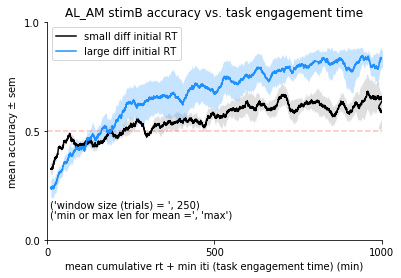

In [16]:
# ~~~~~~ plotting ~~~~~~~
    
x = stimB_rtminiti_cumsum_fast_mean*0.001*(1/60)
y = stimB_outcome_cumsum_fast_mean
yerr = stimB_outcome_cumsum_fast_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'small diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = stimB_rtminiti_cumsum_slow_mean*0.001*(1/60)
y = stimB_outcome_cumsum_slow_mean
yerr = stimB_outcome_cumsum_slow_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'large diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 500, 1000])
plt.xlim(0,1000)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM stimB accuracy vs. task engagement time')
s = 'window size (trials) = ', window
plt.text(10, 0.15, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.10, s)
plt.legend()
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_acc_v_task_engagement_time_by_initial_diff_RT.pdf')

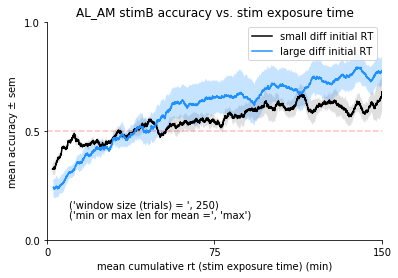

In [19]:
# ~~~~~~ plotting ~~~~~~~
    
x = stimB_rt_cumsum_fast_mean*0.001*(1/60)
y = stimB_outcome_cumsum_fast_mean
yerr = stimB_outcome_cumsum_fast_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'small diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = stimB_rt_cumsum_slow_mean*0.001*(1/60)
y = stimB_outcome_cumsum_slow_mean
yerr = stimB_outcome_cumsum_slow_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'large diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 75, 150])
plt.xlim(0,150)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('mean cumulative rt (stim exposure time) (min)')
plt.title('AL_AM stimB accuracy vs. stim exposure time')
s = 'window size (trials) = ', window
plt.text(10, 0.15, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.10, s)
plt.legend()
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_acc_v_stim_exposure_time_by_initial_diff_RT.pdf')

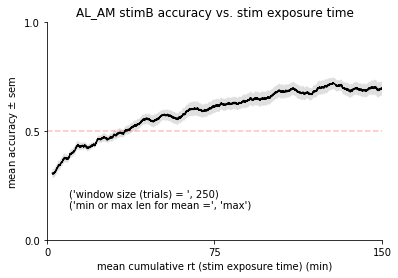

In [20]:
# ~~~~~~ plotting ~~~~~~~
    
x = stimB_rt_cumsum_all_mean*0.001*(1/60)
y = stimB_outcome_cumsum_all_mean
yerr = stimB_outcome_cumsum_all_sem
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 75, 150])
plt.xlim(0,150)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('mean cumulative rt (stim exposure time) (min)')
plt.title('AL_AM stimB accuracy vs. stim exposure time')
s = 'window size (trials) = ', window
plt.text(10, 0.20, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.15, s)
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_acc_v_stim_exposure_time.pdf')

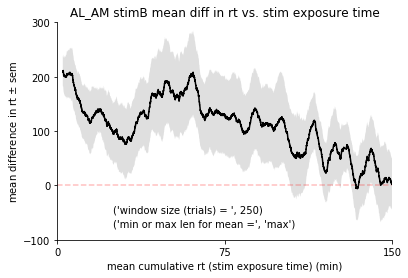

In [21]:
# ~~~~~~ plotting ~~~~~~~

x = stimB_rt_cumsum_all_mean*0.001*(1/60)
y = stimB_rtdiff_trials_all_mean
yerr = stimB_rtdiff_trials_all_sem
    
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

plt.yticks([-100, 0, 100, 200, 300])
plt.ylim(-100, 300)
plt.xticks([0, 75, 150])
plt.xlim(0,150)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean difference in rt $\pm$ sem')
plt.xlabel('mean cumulative rt (stim exposure time) (min)')
plt.title('AL_AM stimB mean diff in rt vs. stim exposure time')
s = 'window size (trials) = ', window
plt.text(25, -50, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(25, -75, s)
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_diff_in_RT_v_stim_exposure_time.pdf')

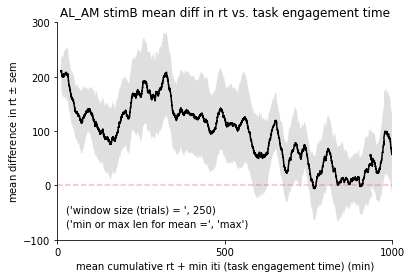

In [58]:
# ~~~~~~ plotting ~~~~~~~

x = stimB_rtminiti_cumsum_all_mean*0.001*(1/60)
y = stimB_rtdiff_trials_all_mean
yerr = stimB_rtdiff_trials_all_sem
    
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

plt.yticks([-100, 0, 100, 200, 300])
plt.ylim(-100, 300)
plt.xticks([0, 500, 1000])
plt.xlim(0,1000)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean difference in rt $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM stimB mean diff in rt vs. task engagement time')
s = 'window size (trials) = ', window
plt.text(25, -50, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(25, -75, s)
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_diff_in_RT_v_task_engagement_time.pdf')

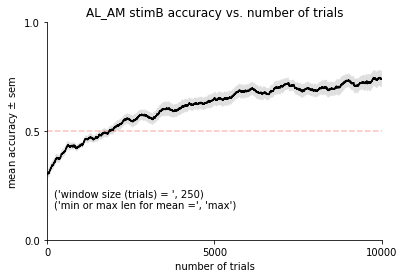

In [23]:
# ~~~~~~ plotting ~~~~~~~
    
x = np.array(range(len(stimB_outcome_cumsum_all_mean)))+1
y = stimB_outcome_cumsum_all_mean
yerr = stimB_outcome_cumsum_all_sem
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 5000, 10000])
plt.xlim(0,10000)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('number of trials')
plt.title('AL_AM stimB accuracy vs. number of trials')
s = 'window size (trials) = ', window
plt.text(200, 0.20, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(200, 0.15, s)
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_acc_v_num_of_trials.pdf')

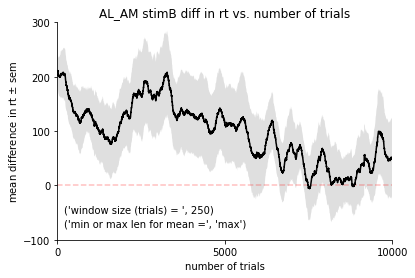

In [24]:
# ~~~~~~ plotting ~~~~~~~

x = np.array(range(len(stimB_rtdiff_trials_all_mean)))+1
y = stimB_rtdiff_trials_all_mean
yerr = stimB_rtdiff_trials_all_sem
    
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

plt.yticks([-100, 0, 100, 200, 300])
plt.ylim(-100, 300)
plt.xticks([0, 5000, 10000])
plt.xlim(0,10000)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean difference in rt $\pm$ sem')
plt.xlabel('number of trials')
plt.title('AL_AM stimB diff in rt vs. number of trials')
s = 'window size (trials) = ', window
plt.text(200, -50, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(200, -75, s)
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_diff_in_RT_v_num_of_trials.pdf')

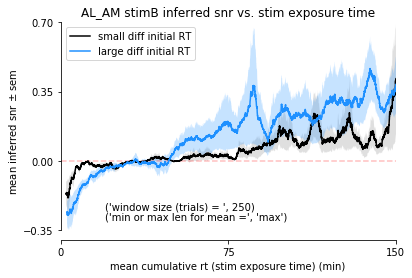

In [42]:
# ~~~~~~ plotting ~~~~~~~

# set negative SNRs to 0
set_neg_snr_to_0 = False

if set_neg_snr_to_0 == True:
    y = [0 if i<0 else i for i in stimB_snr_cumsum_fast_mean]
    yerr = []
    for i in range(len(y)):
        if y[i] == 0:
            yerr.append(0)
        else:
            yerr.append(stimB_snr_cumsum_fast_sem[i])            
else:
    y = stimB_snr_cumsum_fast_mean
    yerr = stimB_snr_cumsum_fast_sem
y = np.array(y)
yerr = np.array(yerr)
x = stimB_rt_cumsum_fast_mean*0.001*(1/60)
plt.errorbar(x = x, y = y, color = 'k', label = 'small diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

if set_neg_snr_to_0 == True:
    y = [0 if i<0 else i for i in stimB_snr_cumsum_slow_mean]
    yerr = []
    for i in range(len(y)):
        if y[i] == 0:
            yerr.append(0)
        else:
            yerr.append(stimB_snr_cumsum_slow_sem[i])  
else:
    y = stimB_snr_cumsum_slow_mean
    yerr = stimB_snr_cumsum_slow_sem
y = np.array(y)
yerr = np.array(yerr)
x = stimB_rt_cumsum_slow_mean*0.001*(1/60)
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'large diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([-0.35, 0, 0.35, 0.7])
plt.ylim([-0.4, 0.7])
plt.xticks([0, 75, 150])
plt.xlim(0,150)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean inferred snr $\pm$ sem')
plt.xlabel('mean cumulative rt (stim exposure time) (min)')
plt.title('AL_AM stimB inferred snr vs. stim exposure time')
s = 'window size (trials) = ', window
plt.text(20, -0.25, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(20, -0.30, s)
plt.legend(loc = 'upper left')
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_inferred_SNR_v_stim_exposure_time_by_initial_diff_RT.pdf')

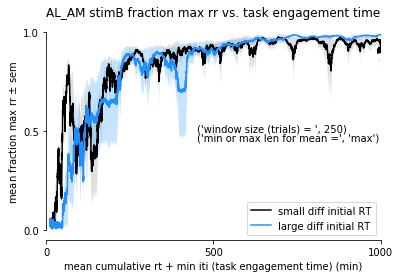

In [46]:
# ~~~~~~ plotting ~~~~~~~
    
x = stimB_rtminiti_cumsum_fast_mean*0.001*(1/60)
y = stimB_fracmaxrr_cumsum_fast_mean
yerr = stimB_fracmaxrr_cumsum_fast_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'small diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)


x = stimB_rtminiti_cumsum_slow_mean*0.001*(1/60)
y = stimB_fracmaxrr_cumsum_slow_mean
yerr = stimB_fracmaxrr_cumsum_slow_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'large diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 500, 1000])
plt.xlim(0,1000)
plt.ylabel('mean fraction max rr $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM stimB fraction max rr vs. task engagement time')
s = 'window size (trials) = ', window
plt.text(450, 0.5, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(450, 0.45, s)
plt.legend(loc = 'lower right')
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_frac_max_RR_v_task_engagement_time_by_initial_diff_RT.pdf')

## Reward Rate vs RT change (slowest and fastest groups)

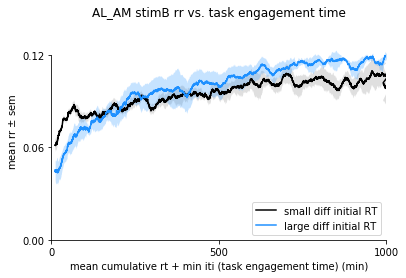

In [52]:
# ~~~~~~ plotting ~~~~~~~
    
x = stimB_rtminiti_cumsum_fast_mean*0.001*(1/60)
y = stimB_rractual_cumsum_fast_mean
yerr = stimB_rractual_cumsum_fast_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'small diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)


x = stimB_rtminiti_cumsum_slow_mean*0.001*(1/60)
y = stimB_rractual_cumsum_slow_mean
yerr = stimB_rractual_cumsum_slow_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'large diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.06, 0.12])
plt.xticks([0, 500, 1000])
plt.xlim(0,1000)
plt.ylabel('mean rr $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM stimB rr vs. task engagement time')
plt.legend(loc = 'lower right')
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_RR_v_task_engagement_time_by_initial_diff_RT.pdf')

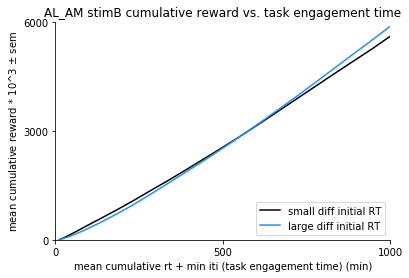

In [53]:
# ~~~~~~ plotting ~~~~~~~
    
x = stimB_rtminiti_cumsum_fast_mean*0.001*(1/60)
y = stimB_rractual_cumsum_cumsum_fast_mean*0.001
plt.errorbar(x = x, y = y, color = 'k', label = 'small diff initial RT')

x = stimB_rtminiti_cumsum_slow_mean*0.001*(1/60)
y = stimB_rractual_cumsum_cumsum_slow_mean*0.001
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'large diff initial RT')

plt.yticks([0,3000,6000])
plt.ylim(0,6000)
plt.xticks([0, 500, 1000])
plt.xlim(0,1000)
plt.ylabel('mean cumulative reward * 10^3 $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM stimB cumulative reward vs. task engagement time')
plt.legend(loc = 'lower right')
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_cumulative_reward_v_task_engagement_time_by_initial_diff_RT.pdf')

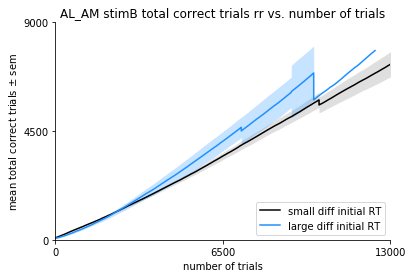

In [54]:
# ~~~~~~ plotting ~~~~~~~
    
x = np.array(range(len(stimB_numcorr_cumsum_fast_mean)))+1
y = stimB_numcorr_cumsum_fast_mean
yerr = stimB_numcorr_cumsum_fast_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'small diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = np.array(range(len(stimB_numcorr_cumsum_slow_mean)))+1
y = stimB_numcorr_cumsum_slow_mean
yerr = stimB_numcorr_cumsum_slow_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'large diff initial RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 4500, 9000])
plt.ylim(0,9000)
plt.xticks([0, 6500, 13000])
plt.xlim(0,13000)
# plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean total correct trials $\pm$ sem')
plt.xlabel('number of trials')
plt.title('AL_AM stimB total correct trials rr vs. number of trials')
plt.legend(loc = 'lower right')
sns.despine(trim = True)
plt.savefig('_graphs_old_v_new_stim/AL_AM_mean_total_corr_trials_v_num_of_trials_by_initial_diff_RT.pdf')

### OPC plots

In [112]:
T0 = 160
Derr = 3136
Dcorr = 6370
boundary = 500
with_itis = False

stimB_iti_succ_adj = adjust_itis(stimB_iti_succ, Dcorr)
stimB_iti_succ_adj_mean, stimB_iti_succ_adj_sem, stimB_iti_succ_adj_median = avg_adjusted_itis(stimB_iti_succ_adj, boundary)

stimB_iti_fail_adj = adjust_itis(stimB_iti_fail, Derr)
stimB_iti_fail_adj_mean, stimB_iti_fail_adj_sem, stimB_iti_fail_adj_median = avg_adjusted_itis(stimB_iti_fail_adj, boundary)

stimB_dt = convert_RTs_to_DTs(stimB_rt_succ, stimB_iti_fail_adj_mean, T0, Derr, with_itis)
stimB_dt_err = calc_DT_err(stimB_rt_succ_err, stimB_iti_fail_adj_sem, T0, Derr, with_itis)

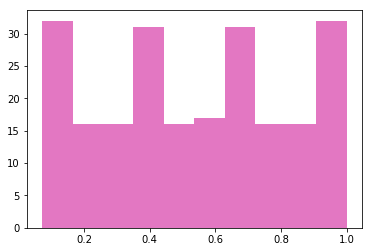

In [117]:
# mesh data

meshed_stimB_rt = mesh_data(stimB_rt_succ, 'none')
meshed_stimB_dt = mesh_data(stimB_dt, 'none')
meshed_stimB_perf = mesh_data(stimB_perf, 'none')
meshed_stimB_iti_err = mesh_data(stimB_iti_fail_adj_mean, 'none')
meshed_stimB_iti_corr = mesh_data(stimB_iti_succ_adj_mean, 'none')
meshed_stimB_iti_err_median = mesh_data(stimB_iti_fail_adj_median, 'none')
meshed_stimB_iti_corr_median = mesh_data(stimB_iti_succ_adj_median, 'none')

meshed_stimB_iti_err_raw = mesh_data(stimB_iti_fail_adj, 'none')

n_bins = 10
binned_avg_stimB_rt = avg_binned_data(meshed_stimB_rt, n_bins)
binned_avg_stimB_dt = avg_binned_data(meshed_stimB_dt, n_bins)
binned_avg_stimB_perf = avg_binned_data(meshed_stimB_perf, n_bins)
binned_avg_stimB_iti_err = avg_binned_data(meshed_stimB_iti_err, n_bins)
binned_avg_stimB_iti_corr = avg_binned_data(meshed_stimB_iti_corr, n_bins)
binned_avg_stimB_iti_err_median = avg_binned_data(meshed_stimB_iti_err_median, n_bins)
binned_avg_stimB_iti_corr_median = avg_binned_data(meshed_stimB_iti_corr_median, n_bins)

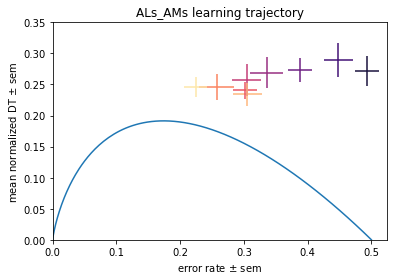

In [123]:
opc_during_learning_from_list(binned_avg_stimB_perf['y_bins_mean'], binned_avg_stimB_perf['y_bins_sem'], binned_avg_stimB_dt['y_bins_mean'], binned_avg_stimB_dt['y_bins_sem'],'ALs_AMs','_graphs_opc_during_learning/ALs_AMs_opc_during_learning_with_no_vol_itis_t0_160ms_10bins.pdf')

In [275]:
relevant_data = 'avg_rt_success_by_session'

stimB_RTs = {}
fullcross_RTs = {}

for animal in results_stimB.iterkeys():
    for session in sorted(results_stimB[animal][relevant_data]):
        try:
            stimB_RTs[animal].append(results_stimB[animal][relevant_data][session])
        except KeyError:
            stimB_RTs[animal] = [results_stimB[animal][relevant_data][session]]
            
for animal in results_stimB_base.iterkeys():
    for session in sorted(results_stimB_base[animal][relevant_data]):
        try:
            fullcross_RTs[animal].append(results_stimB_base[animal][relevant_data][session])
        except KeyError:
            fullcross_RTs[animal] = [results_stimB_base[animal][relevant_data][session]]  

In [276]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
animals = []


# if using limited number of sessions at ends

sessions_to_count = 2

for animal in sorted(stimB_RTs.keys()):
    animals.append(animal)
    stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
    fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    
# # if using all stimB sessions, take equivalent number of fullcross sessions

# for animal in sorted(stimB_RTs.keys()):
#     animals.append(animal)
#     stimB_mean_RTs.append(np.mean(stimB_RTs[animal]))
#     fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-len(stimB_RTs[animal]):]))
    

print fullcross_mean_RTs  

[1481.2066201634648, 1116.7132770439148, 1611.9616367924527, 725.39781375871189, 619.96687455693768, 942.72160319148929, 627.22930509635785, 698.12884956488676, 847.99586969889015, 803.70258981272627, 811.96680055010484, 1159.3795083073487, 739.25899242246419, 830.25622947761201, 872.10822959999996, 928.5276956033947]


In [278]:
stats.shapiro(stimB_mean_RTs), stats.shapiro(fullcross_mean_RTs),\
stats.levene(stimB_mean_RTs, fullcross_mean_RTs)

((0.883098304271698, 0.043377410620450974),
 (0.849763035774231, 0.013515360653400421),
 LeveneResult(statistic=0.69549893795736206, pvalue=0.41089173460400741))

In [279]:
t, p = stats.wilcoxon(stimB_mean_RTs, fullcross_mean_RTs)
t,p

(13.0, 0.0044553523554717407)

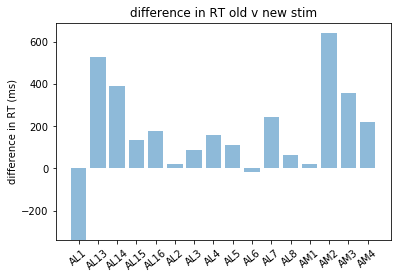

In [280]:
objects = animals
y_pos = np.arange(len(objects))
diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)
 
plt.bar(y_pos, diffs, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation = '40')
plt.ylabel('difference in RT (ms)')
plt.title('difference in RT old v new stim')
# plt.savefig('difference_in_RTs_fullcross_v_stimB.pdf')

In [281]:
fullcross_mean_RTs_1 = []
fullcross_mean_RTs_2 = []
animals = []


# if using limited number of sessions at ends

sessions_to_count = 2

# for animal in sorted(stimB_RTs.keys()):
#     animals.append(animal)
#     fullcross_mean_RTs_1.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
#     fullcross_mean_RTs_2.append(np.mean(fullcross_RTs[animal][-2*sessions_to_count:-sessions_to_count]))
    

for animal in sorted(stimB_RTs.keys()):
    if animal == 'AL13':
        pass
    else:
        animals.append(animal)
        fullcross_mean_RTs_1.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
        fullcross_mean_RTs_2.append(np.mean(fullcross_RTs[animal][:sessions_to_count]))


In [282]:
stats.shapiro(fullcross_mean_RTs_1), stats.shapiro(fullcross_mean_RTs_2),\
stats.levene(fullcross_mean_RTs_1, fullcross_mean_RTs_2)

((0.8128393888473511, 0.005398295819759369),
 (0.9274288415908813, 0.24968577921390533),
 LeveneResult(statistic=0.36495875147906481, pvalue=0.550629008415503))

In [283]:
t2, p2 = stats.wilcoxon(fullcross_mean_RTs_1, fullcross_mean_RTs_2)
t2, p2

(10.0, 0.0045140528549171407)

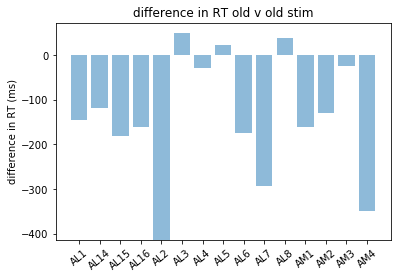

In [284]:
objects = animals
y_pos = np.arange(len(objects))
diffs = np.subtract(fullcross_mean_RTs_1, fullcross_mean_RTs_2)
 
plt.bar(y_pos, diffs, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation = '40')
plt.ylabel('difference in RT (ms)')
plt.title('difference in RT old v old stim')
# plt.savefig('difference_in_RTs_fullcross_v_fullcross.pdf')

0.0035


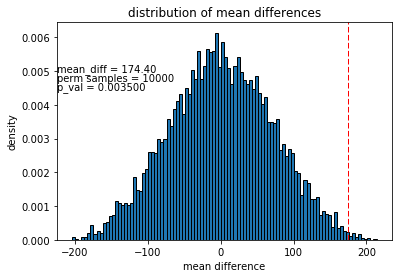

In [285]:
# Permutation test

diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)

nreps = 10000

means = []
for i in range(nreps):
    sign_dist = [random.choice([-1, 1]) for i in range(len(diffs))]
    perm = np.multiply(diffs, sign_dist)
    perm_mean = np.mean(perm)
    means.append(perm_mean)
    
hits = 0
for i in means:
    if i > np.mean(diffs):
        hits += 1
    else:
        pass

p_val = hits/len(means)

print p_val


plt.hist(means, bins = 100, normed = True, edgecolor = 'k')
plt.axvline(diffs.mean(), color='r', linestyle='dashed', linewidth=1)
plt.ylabel('density')
plt.xlabel('mean difference')
plt.title('distribution of mean differences')
plt.text(-225, 0.005, 'mean_diff = %.2f'% diffs.mean())
plt.text(-225, 0.00470, 'perm samples = %i' % nreps)
plt.text(-225, 0.00445, 'p_val = %f' % p_val)
# plt.savefig('perm_test_hist_rt_old_v_new_shapes_2_sessions_before_and_after.pdf')

## Learning Speed

In [286]:
relevant_data = 'pct_correct_by_session'

stimB_perf = {}
fullcross_perf = {}

for animal in results_stimB.iterkeys():
    for session in sorted(results_stimB[animal][relevant_data]):
        try:
            stimB_perf[animal].append(results_stimB[animal][relevant_data][session])
        except KeyError:
            stimB_perf[animal] = [results_stimB[animal][relevant_data][session]]
            
for animal in results_stimB_base.iterkeys():
    for session in sorted(results_stimB_base[animal][relevant_data]):
        try:
            fullcross_perf[animal].append(results_stimB_base[animal][relevant_data][session])
        except KeyError:
            fullcross_perf[animal] = [results_stimB_base[animal][relevant_data][session]]

In [287]:
# new performance list that eliminates plateaus and just keeps learning phase up to that point

stimB_perf_trunc = {}
for animal in stimB_perf.keys():
    data = stimB_perf[animal]
    trunc_data = []
    thresh = 0.95
    max_p = max(data)
    for p in data:
        if p <= thresh*max_p:
            trunc_data.append(p)
        elif p > thresh*max_p:
            break
    
    stimB_perf_trunc[animal] = trunc_data

In [288]:
# new performance list that finds asymptotic performance

stimB_top_perf = {}

for animal in stimB_perf.keys():
    print 'animal:', animal
    data = stimB_perf[animal]
    trunc_data = []
    thresh = 0.95
    max_p = max(data)
    print 'max for animal:', max_p
    for p in data:
        if p >= thresh*max_p:
            print p
            trunc_data.append(p)
        elif p < thresh*max_p:
            pass
    
    data_dict = {
        'sessions_top_perf': trunc_data,
        'mean_top_perf': np.mean(trunc_data),
        'sem_top_perf': np.std(trunc_data)/math.sqrt(len(trunc_data))
    }
    
    stimB_top_perf[animal] = data_dict

animal: AL4
max for animal: 0.780035335689
0.75
0.780035335689
0.770642201835
0.74628879892
animal: AL13
max for animal: 0.909698996656
0.878338278932
0.882750845547
0.893018018018
0.894150417827
0.885483870968
0.909698996656
animal: AL14
max for animal: 0.87915407855
0.847222222222
0.87915407855
0.87537993921
animal: AL15
max for animal: 0.712396694215
0.678025851939
0.706601466993
0.712396694215
animal: AL16
max for animal: 0.826833073323
0.796610169492
0.826833073323
animal: AL3
max for animal: 0.883879781421
0.850674373796
0.866749688667
0.88125
0.883879781421
animal: AL6
max for animal: 0.784447476126
0.769165247019
0.750798722045
0.784447476126
0.775884665793
animal: AL8
max for animal: 0.846385542169
0.846385542169
animal: AL5
max for animal: 0.702849389417
0.693208430913
0.702849389417
animal: AM1
max for animal: 0.609913793103
0.585141903172
0.585086042065
0.609913793103
0.6
animal: AL7
max for animal: 0.828244274809
0.828244274809
0.822314049587
animal: AM3
max for animal: 0.

In [289]:
# linear regression on truncated performance data

data_dict = stimB_perf_trunc

fit_dict = {}
for key in data_dict.keys():
    # turn x-axis into sessions based on index of performance data
    x = [i+1 for i in range(len(data_dict[key]))]
    y = data_dict[key]
    
    # 1-D polynomial fit, e.g. linear regression
    par = np.polyfit(x, y, 1, full=True)
    
    slope = par[0][0]
    intercept = [par][0][1]
    # make line of best fit ('lobf')
    x_of_lobf = [min(x), max(x)]
    y_of_lobf = [slope*xx + intercept  for xx in x_of_lobf]
    
    fit_data = {
        'slope': slope,
        'intercept': intercept,
        'x_of_lobf': x_of_lobf,
        'y_of_lobf': y_of_lobf
    }
    
    fit_dict[key] = fit_data
    

stimB_learningspeed = fit_dict

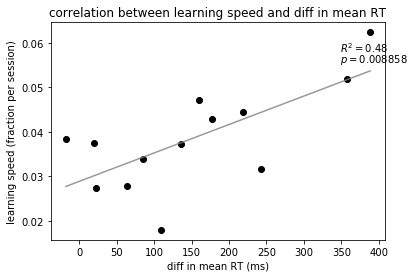

In [290]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
stimB_learningspeedlist = []
animals = []

# if using limited number of sessions at ends

sessions_to_count = 2
for animal in sorted(stimB_RTs.keys()):
    if animal not in ['AL1', 'AL13', 'AM2']: # in case you want to eliminate animals from the analysis
        animals.append(animal)
        stimB_learningspeedlist.append(stimB_learningspeed[animal]['slope'])
        stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    else:
        pass

diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)
learningspeed = stimB_learningspeedlist # units are fraction per session (fraction being performance from 0 to 1)
# learningspeed = [i*100 for i in stimB_learningspeedlist] # convert to percent


# 1-D polynomial fit, e.g. linear regression
x = diffs
y = learningspeed

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(diffs, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

# plt.ylim(0, 0.15)
# plt.xlim(-400, 800)
plt.xlabel('diff in mean RT (ms)')
plt.ylabel('learning speed (fraction per session)')
plt.title('correlation between learning speed and diff in mean RT')
# plt.savefig('corr_btwn_diffinmeanRT_new_v_old_stim_and_learningspeed_new_stim_extended.pdf')

In [291]:
stimB_learningspeed['AM1']['slope']

0.027256139493313604

In [292]:
np.mean(stimB_RTs['AM1'][:2]) - np.mean(fullcross_RTs['AM1'][-2:])

21.721812670362851

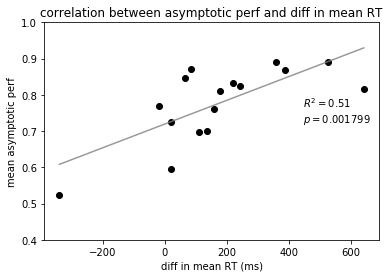

In [293]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
stimB_top_perf_list = []
animals = []

# if using limited number of sessions at ends

sessions_to_count = 2
for animal in sorted(stimB_RTs.keys()):
#     if animal not in ['AL1', 'AL13', 'AM2']: # in case you want to eliminate animals from the analysis
    if animal not in ['add trouble animals here']:
        animals.append(animal)
        stimB_top_perf_list.append(stimB_top_perf[animal]['mean_top_perf'])
        stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    else:
        pass

diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)
top_perf = stimB_top_perf_list


# 1-D polynomial fit, e.g. linear regression
x = diffs
y = top_perf

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.80*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.725*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(diffs, top_perf, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.ylim(0.4, 1.0)
# plt.xlim(-400, 800)
plt.xlabel('diff in mean RT (ms)')
plt.ylabel('mean asymptotic perf')
plt.title('correlation between asymptotic perf and diff in mean RT')
# plt.savefig('corr_btwn_diffinmeanRT_new_v_old_stim_and_asymptotic_perf_new_stim_extended.pdf')

## Initial change in RT versus initial ER

### initial difference in error rate versus initial difference in reaction time correlate strongly

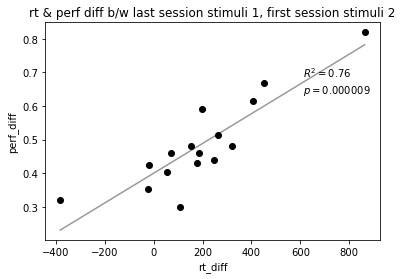

In [26]:
# relevant data files
stimB_RTs
fullcross_RTs
stimB_perf
fullcross_perf

sessions_to_count = 1

# rt_diff = {}
# perf_diff = {}
# for animal in stimB_perf.keys():
#     rt_diff[animal] = np.mean(stimB_RTs[animal][:sessions_to_count]) - np.mean(fullcross_RTs[animal][-sessions_to_count:])
#     perf_diff[animal] = np.mean(fullcross_perf[animal][:sessions_to_count]) - np.mean(stimB_perf[animal][-sessions_to_count:])

rt_diff = []
perf_diff = []
for animal in sorted(stimB_perf.keys()):
    rt_diff.append(np.mean(stimB_RTs[animal][:sessions_to_count]) - np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    perf_diff.append(np.mean(fullcross_perf[animal][-sessions_to_count:]) - np.mean(stimB_perf[animal][:sessions_to_count]))

    
# 1-D polynomial fit, e.g. linear regression
x = rt_diff
y = perf_diff

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.80*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.725*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)


plt.plot(rt_diff, perf_diff, color = 'k', marker = 'o', linestyle = ' ')
plt.xlabel('rt_diff')
plt.ylabel('perf_diff')
plt.title('rt & perf diff b/w last session stimuli 1, first session stimuli 2')
# plt.savefig('ALs_AMs_rt_&_perf_diff_bw_last_sesh_stim1_first_sesh_stim2.pdf')

### absolute error rates and reaction times correlate but less than differences on stim pair 2

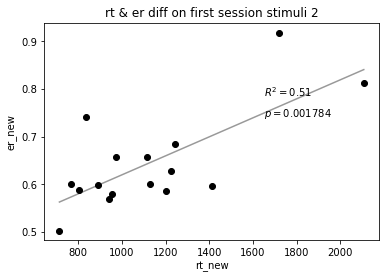

In [28]:
# relevant data files
stimB_RTs
fullcross_RTs
stimB_perf
fullcross_perf

sessions_to_count = 1

# rt_diff = {}
# perf_diff = {}
# for animal in stimB_perf.keys():
#     rt_diff[animal] = np.mean(stimB_RTs[animal][:sessions_to_count]) - np.mean(fullcross_RTs[animal][-sessions_to_count:])
#     perf_diff[animal] = np.mean(fullcross_perf[animal][:sessions_to_count]) - np.mean(stimB_perf[animal][-sessions_to_count:])

rt_new = []
perf_new = []
for animal in sorted(stimB_perf.keys()):
    rt_new.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
    perf_new.append(1 - np.mean(stimB_perf[animal][:sessions_to_count]))

    
# 1-D polynomial fit, e.g. linear regression
x = rt_new
y = perf_new

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.80*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.725*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)


plt.plot(x, y, color = 'k', marker = 'o', linestyle = ' ')
plt.xlabel('rt_new')
plt.ylabel('er_new')
plt.title('rt & er diff on first session stimuli 2')
# plt.savefig('ALs_AMs_rt_&_er_first_sesh_stim2.pdf')

### error rates and reaction times look uncorrelated during asymptotic performance on stim pair 1

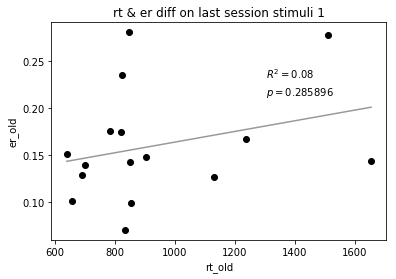

In [29]:
# relevant data files
stimB_RTs
fullcross_RTs
stimB_perf
fullcross_perf

sessions_to_count = 1

# rt_diff = {}
# perf_diff = {}
# for animal in stimB_perf.keys():
#     rt_diff[animal] = np.mean(stimB_RTs[animal][:sessions_to_count]) - np.mean(fullcross_RTs[animal][-sessions_to_count:])
#     perf_diff[animal] = np.mean(fullcross_perf[animal][:sessions_to_count]) - np.mean(stimB_perf[animal][-sessions_to_count:])

rt_old = []
perf_old = []
for animal in sorted(fullcross_perf.keys()):
    rt_old.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    perf_old.append(1 - np.mean(fullcross_perf[animal][-sessions_to_count:]))

    
# 1-D polynomial fit, e.g. linear regression
x = rt_old
y = perf_old

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.80*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.75*max(x)+.1*min(x),.725*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)


plt.plot(x, y, color = 'k', marker = 'o', linestyle = ' ')
plt.xlabel('rt_old')
plt.ylabel('er_old')
plt.title('rt & er diff on last session stimuli 1')
# plt.savefig('ALs_AMs_rt_&_er_last_sesh_stim1.pdf')

# Change in RT from baseline mean

In [9]:
# gather the RT data into dictionaries

relevant_data = 'avg_rt_success_by_session'

stimB_RTs = {}
fullcross_RTs = {}

for animal in results_stimB.iterkeys():
    for session in sorted(results_stimB[animal][relevant_data]):
        try:
            stimB_RTs[animal].append(results_stimB[animal][relevant_data][session])
        except KeyError:
            stimB_RTs[animal] = [results_stimB[animal][relevant_data][session]]
            
for animal in results_stimB_base.iterkeys():
    for session in sorted(results_stimB_base[animal][relevant_data]):
        try:
            fullcross_RTs[animal].append(results_stimB_base[animal][relevant_data][session])
        except KeyError:
            fullcross_RTs[animal] = [results_stimB_base[animal][relevant_data][session]] 

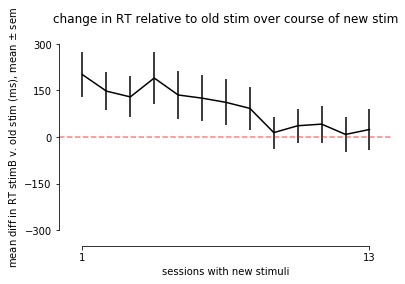

In [22]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
animals = []

# get means / if using limited number of sessions at ends

sessions_to_count = 2

for animal in sorted(stimB_RTs.keys()):
    if animal not in []: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        animals.append(animal)
        stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    else:
        pass

# Permutation test

diffs = []
for animal in sorted(stimB_RTs.keys()):
    if animal not in []: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        diff = [i - np.mean(fullcross_RTs[animal][-sessions_to_count:]) for i in stimB_RTs[animal]]
        diffs.append(diff)

        y = diff
        x = [i+1 for i in range(len(y))]
#         plt.plot(x,y, label = animal, color = 'gray', alpha = 0.5)
    else:
        pass


diff_lengths = []
for l in diffs:
    diff_lengths.append(len(l))

for i in range(len(diffs)):
    diffs[i] = diffs[i][:13]
    

diffs_avg = np.average(diffs, axis = 0)
std = np.std(diffs, axis = 0)
sem = std / math.sqrt(len(diffs_avg))

y = diffs_avg
x = [i+1 for i in range(len(y))]
              
plt.errorbar(x, y, yerr = sem, color = 'k')
# # plt.yscale('symlog')
# plt.ylim(-200, 1200)
plt.ylim(-350, 350)
plt.yticks([-300,-150,0,150,300])
plt.xlim(0, 14)
plt.xticks([1,13])
plt.axhline(y = 0, linestyle = '--', color = 'r', alpha = 0.5)
plt.xlabel('sessions with new stimuli')
plt.ylabel('mean diff in RT stimB v. old stim (ms), mean $\pm$ sem')
plt.title('change in RT relative to old stim over course of new stim')
sns.despine(trim = 'True')
plt.savefig('_graphs_old_v_new_stim/ALs_AMs_avg_change_in_RT_v_oldstimbaseline_for_new_stim.pdf')

In [32]:
nreps = 10000

transposed_diffs = np.transpose(diffs) # diffs sorted by animal, this sorts it by session instead
p_vals_by_session = []
for j in transposed_diffs:
    means = []
    for i in range(nreps):
        sign_dist = [random.choice([-1, 1]) for k in range(len(j))]
        perm = np.multiply(j, sign_dist)
        perm_mean = np.mean(perm)
        means.append(perm_mean)
        
    hits = 0
    for m in means:
        if m > np.mean(j):
            hits += 1
        else:
            pass
    p_val = hits/len(means)
    
    p_vals_by_session.append(p_val)

print p_vals_by_session

# plt.hist(means, bins = 100, normed = True, edgecolor = 'k')
# plt.axvline(diffs.mean(), color='r', linestyle='dashed', linewidth=1)
# plt.ylabel('density')
# plt.xlabel('mean difference')
# plt.title('distribution of mean differences')
# plt.text(-225, 0.005, 'mean_diff = %.2f'% diffs.mean())
# plt.text(-225, 0.00470, 'perm samples = %i' % nreps)
# plt.text(-225, 0.00445, 'p_val = %f' % p_val)
# plt.savefig('perm_test_hist_rt_old_v_new_shapes_2_sessions_before_and_after.pdf')

[0.0034, 0.0069, 0.0165, 0.0071, 0.0291, 0.0347, 0.06, 0.0946, 0.3948, 0.244, 0.244, 0.4497, 0.3437]


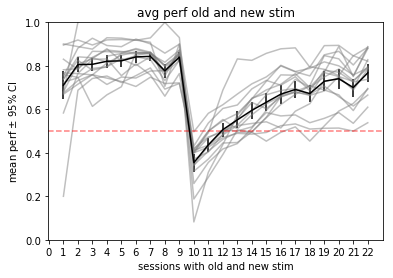

In [34]:
# Plot change in RT from baseline for this condition

stimB_perf
fullcross_perf

sessions_to_count = 9
condition = 'A'

diffs = []
perfs = []
for animal in sorted(stimB_perf.keys()):
    if condition in animal: # or 'AK2' in animal or 'AK10' in animal: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        diff = [i - np.mean(fullcross_perf[animal][-sessions_to_count:]) for i in stimB_perf[animal]]
        diffs.append(diff)
#         perf = fullcross_perf[animal][-sessions_to_count:] + [float('nan')] + stimB_perf[animal][:13]
        perf = fullcross_perf[animal][-sessions_to_count:] + stimB_perf[animal][:13]
        perfs.append(perf)
        

#         y = diff
        y = perf
        x = [i+1 for i in range(len(y))]
        plt.plot(x, y, label = animal, color = 'gray', alpha = 0.5)
    else:
        pass


# diff_lengths = []
# for l in diffs:
#     diff_lengths.append(len(l))

# n_of_sessions = 13
# for i in range(len(diffs)):
#     diffs[i] = diffs[i][:n_of_sessions]
    

# diffs_avg = np.nanmean(diffs[:5], axis = 0)
# std = np.nanstd(diffs[:5], axis = 0)
# sem = std / math.sqrt(len(diffs_avg))

perfs_avg = np.nanmean(perfs, axis = 0)
std = np.nanstd(perfs, axis = 0)
sem = std / math.sqrt(len(perfs_avg))

# y = diffs_avg
y = perfs_avg
x = [i+1 for i in range(len(y))]
              
plt.errorbar(x, y, yerr = 1.96*sem, color = 'k')
# plt.errorbar(x, y, color = 'k')
# plt.ylim(-75, 275)
plt.xticks(range(len(x) + 1))
plt.ylim (0.0, 1.0)
plt.axhline(y = 0.5, linestyle = '--', color = 'r', alpha = 0.5)
plt.xlabel('sessions with old and new stim')
# plt.ylabel('mean diff in perf visible v. alpha=0.0 stim (ms), mean $\pm$ 95% CI')
plt.ylabel('mean perf $\pm$ 95% CI')
# plt.ylabel('diff in RT visible v. alpha=0.0 stim (ms)')
# plt.title('avg change in perf relative to visible over alpha=0.0 stim')
plt.title('avg perf old and new stim')
# plt.savefig('avg_perf_AM_AL_Cohorts_old_and_new_stim_9_before_13_after.pdf')

AL1
mean of last 2 fullcross sessions: 338.885979139
AL13
mean of last 2 fullcross sessions: -524.397450084
AL14
mean of last 2 fullcross sessions: -388.432208494
AL15
mean of last 2 fullcross sessions: -135.774829322
AL16
mean of last 2 fullcross sessions: -177.214908832
AL2
mean of last 2 fullcross sessions: -20.222723759
AL3
mean of last 2 fullcross sessions: -85.4600534156
AL4
mean of last 2 fullcross sessions: -160.089241201
AL5
mean of last 2 fullcross sessions: -109.813959722
AL6
mean of last 2 fullcross sessions: 17.9706625124
AL7
mean of last 2 fullcross sessions: -243.243190927
AL8
mean of last 2 fullcross sessions: -63.8233761043
AM1
mean of last 2 fullcross sessions: -21.7218126704
AM2
mean of last 2 fullcross sessions: -640.702315394
AM3
mean of last 2 fullcross sessions: -357.204082569
AM4
mean of last 2 fullcross sessions: -219.230937845


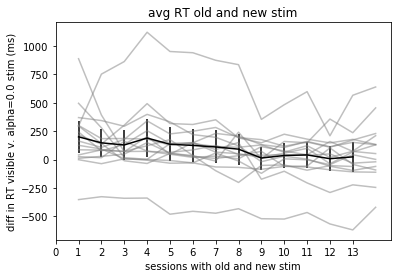

In [35]:
# Plot change in RT from baseline for this condition

stimB_RTs
fullcross_RTs

sessions_to_count = 2
condition = 'A'

diffs = []
RTs = []
for animal in sorted(stimB_perf.keys()):
    if condition in animal: # or 'AK2' in animal or 'AK10' in animal: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        print animal
        print 'mean of last 2 fullcross sessions:', np.mean(fullcross_RTs[animal][-2:]) - np.mean(stimB_RTs[animal][:2])
        diff = [i - np.mean(fullcross_RTs[animal][-sessions_to_count:]) for i in stimB_RTs[animal]]
        diffs.append(diff)
#         RT = fullcross_RTs[animal][-sessions_to_count:] + [float('nan')] + stimB_RTs[animal][:13]
        RT = fullcross_RTs[animal][-sessions_to_count:] + stimB_RTs[animal][:13]
        RTs.append(RT)
        

        y = diff
#         y = RT
        x = [i+1 for i in range(len(y))]
        plt.plot(x, y, label = animal, color = 'gray', alpha = 0.5)
    else:
        pass


diff_lengths = []
for l in diffs:
    diff_lengths.append(len(l))

n_of_sessions = 13
for i in range(len(diffs)):
    diffs[i] = diffs[i][:n_of_sessions]
    

diffs_avg = np.nanmean(diffs, axis = 0)
std = np.nanstd(diffs, axis = 0)
sem = std / math.sqrt(len(diffs_avg))

# RTs_avg = np.nanmean(RTs, axis = 0)
# std = np.nanstd(RTs, axis = 0)
# sem = std / math.sqrt(len(RTs_avg))

y = diffs_avg
# y = RTs_avg
x = [i+1 for i in range(len(y))]
              
plt.errorbar(x, y, yerr = 1.96*sem, color = 'k')
# plt.errorbar(x, y, color = 'k')
# plt.ylim(-75, 275)
plt.xticks(range(len(x) + 1))
# plt.ylim (0.0, 1.0)
# plt.axhline(y = 0.5, linestyle = '--', color = 'r', alpha = 0.5)
plt.xlabel('sessions with old and new stim')
# plt.ylabel('mean diff in perf visible v. alpha=0.0 stim (ms), mean $\pm$ 95% CI')
# plt.ylabel('mean RT $\pm$ 95%CI')
plt.ylabel('diff in RT visible v. alpha=0.0 stim (ms)')
# plt.title('avg change in perf relative to visible over alpha=0.0 stim')
plt.title('avg RT old and new stim')
# plt.savefig('avg_RT_AM_AL_Cohorts_old_and_new_stim_9_before_13_after_95CI.pdf')

# calculate SNR

In [318]:
t0 = 0.16 # 0.32

stimB_Abar = {}
for animal in stimB_RTs.keys():
    for session in range(len(stimB_RTs[animal])):
        ER = 1 - stimB_perf[animal][session]
        DT = np.mean(stimB_RTs[animal][session])*0.001 - t0 # take mean of session, then convert to seconds, then subtract t0
        if ER < 0.5:
            A_bar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
        elif ER > 0.5:
            A_bar = -(1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # make SNR negative
#             A_bar = 0 # make it zero when ER is negative
        try: 
            stimB_Abar[animal].append(A_bar)
        except KeyError:
            stimB_Abar[animal] = [A_bar]

In [319]:
for animal in stimB_Abar.keys():
    print 'animal:', animal
    for i in range(len(stimB_Abar[animal])):
        print stimB_Abar[animal][i]
    print ' '

animal: AL13
-0.0305521148403
-0.000141351365375
0.0819308240099
0.255212126812
0.264688998643
0.337996154017
0.408364709632
0.431005572682
0.302647168264
0.579070384606
0.540813096023
0.504721891977
0.517551861065
0.59286050315
 
animal: AL14
-0.234976869925
-0.111040820392
-0.0321542664316
6.11834249859e-05
-4.2875193902e-05
0.00951750638783
0.0394284661482
0.0738665933947
0.145037540716
0.440580725343
0.426670340626
0.244690376446
0.611589170342
0.605950213555
 
animal: AL15
-0.0535461174431
-0.0535461174431
0.015188790004
0.000447073407449
0.0283351200615
0.0794113634929
0.123181041127
0.174570560536
0.159451268813
0.26571258928
0.144052437357
0.0801611749686
0.154477335783
0.242173324425
 
animal: AL16
-0.374910854883
-0.143416446673
-0.0358236210701
-0.0139167952518
0.000917078204249
0.0477036065347
0.139347344445
0.208764300573
0.184073296598
0.20866608395
0.432935364318
0.370237927493
0.634099481696
0.860682498341
 
animal: AM3
-0.132256021568
-0.0641054588294
-0.0120662760843


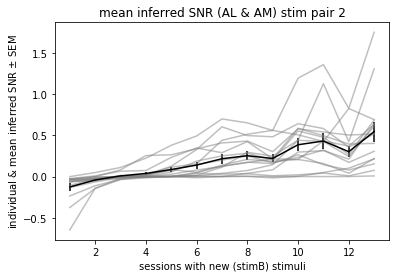

In [320]:
snr1 = []

for animal in sorted(stimB_Abar.keys()):
    if 'Animal' not in animal:# in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
#         diff = [i - np.mean(fullcross_RTs[animal.split('_')[0]][-sessions_to_count:]) for i in transp_RTs[animal]]
#         diffs.append(diff)
        snr = stimB_Abar[animal][:13]
#         perf = fullcross_perf[animal.split('_')[0]][-4:]
#         perf = fullcross_perf[animal.split('_')[0]][-4:] + [float('nan')] + transp_perf[animal]
#         RT = fullcross_RTs[animal.split('_')[0]][-4:] + [float('nan')] + transp_RTs[animal]
#         RTs.append(RT)
        snr1.append(snr)


#         y = diff
        y = snr
#         y = RT 
        x = [i+1 for i in range(len(y))]
        plt.plot(x, y, label = animal, color = 'gray', alpha = 0.5)
    
snr1_avg = np.nanmean(snr1, axis = 0)
std1 = np.nanstd(snr1, axis = 0)
sem1 = std1 / math.sqrt(len(snr1_avg))

y1 = snr1_avg
x = [i+1 for i in range(len(y))]
              
# plt.errorbar(x, y1, yerr = sem1*2.776, color = 'black', label = 'RT upper bound')
# plt.errorbar(x, y2, yerr = sem2*2.365, color = 'dodgerblue', label = 'RT lower bound')
plt.errorbar(x, y1, yerr = sem1, color = 'black', label = 'stim pair 2')
# plt.errorbar(x, y, color = 'k')
# plt.ylim(-75, 275)
# plt.ylim(0, 1.75)
# plt.xlim(0.5,5.5)
# plt.ylim (0.0, 1.0)
# plt.axhline(y = 0.5, linestyle = '--', color = 'r', alpha = 0.5)
plt.xlabel('sessions with new (stimB) stimuli')
# plt.ylabel('individual & mean inferred SNR $\pm$ 95%CI')
plt.ylabel('individual & mean inferred SNR $\pm$ SEM')
plt.title('mean inferred SNR (AL & AM) stim pair 2')
# plt.legend()
# plt.savefig('AL_AM_Cohorts_avg_SNR_stimB_SEM.pdf')

### finding the slope of the SNR across sessions

In [321]:
# new inferred SNR (Abar) list that eliminates values below 0, to measure learning after animals cross accuracy = 50%

stimB_Abar_trunc = {}
for animal in stimB_Abar.keys():
    data = stimB_Abar[animal]
    trunc_data = []
    thresh = 0
    for p in data:
        if p > thresh:
            trunc_data.append(p)
        elif p < thresh:
            pass
    
    stimB_Abar_trunc[animal] = trunc_data

In [322]:
# new inferred SNR (Abar) list that finds asymptotic (or >= 95% of top) performance

stimB_top_Abar = {}

for animal in stimB_Abar.keys():
    data = stimB_Abar[animal]
    trunc_data = []
    thresh = 0.95
    max_p = max(data)
    for p in data:
        if p >= thresh*max_p:
            trunc_data.append(p)
        elif p < thresh*max_p:
            pass
    
    data_dict = {
        'sessions_top_perf': trunc_data,
        'mean_top_perf': np.mean(trunc_data),
        'sem_top_perf': np.std(trunc_data)/math.sqrt(len(trunc_data))
    }
    
    stimB_top_Abar[animal] = data_dict

In [351]:
# linear regression on truncated performance data

data_dict = stimB_Abar_trunc

sessions_to_count = 2
fit_dict = {}
for key in data_dict.keys():
    # turn x-axis into sessions based on index of performance data
    x = [i+1 for i in range(len(data_dict[key][:sessions_to_count]))]
    y = data_dict[key][:sessions_to_count]
    
    # 1-D polynomial fit, e.g. linear regression
    par = np.polyfit(x, y, 1, full=True)
    
    slope = par[0][0]
    intercept = [par][0][1]
    # make line of best fit ('lobf')
    x_of_lobf = [min(x), max(x)]
    y_of_lobf = [slope*xx + intercept  for xx in x_of_lobf]
    
    fit_data = {
        'slope': slope,
        'intercept': intercept,
        'x_of_lobf': x_of_lobf,
        'y_of_lobf': y_of_lobf
    }
    
    fit_dict[key] = fit_data
    

stimB_Abar_learningspeed_from0 = fit_dict

## Correlation between change in SNR and change in RT

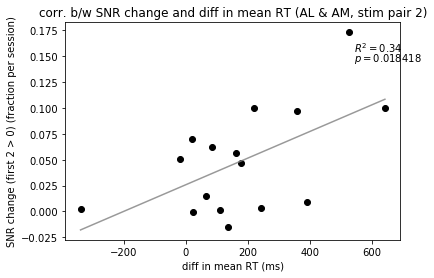

In [355]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
stimB_Abar_learningspeedlist = []
animals = []

# if using limited number of sessions at ends

sessions_to_count = 2
for animal in sorted(stimB_RTs.keys()):
#     if animal not in ['AL1', 'AL13', 'AM2']: # in case you want to eliminate animals from the analysis
#     if animal not in ['AL1', 'AL6']: # animals with negative diff in RT
    if animal not in []:
        animals.append(animal)
        stimB_Abar_learningspeedlist.append(stimB_Abar_learningspeed_from0[animal]['slope'])
        stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    else:
        pass

diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)
learningspeed = stimB_Abar_learningspeedlist # units are fraction per session (fraction being performance from 0 to 1)
# learningspeed = [i*100 for i in stimB_learningspeedlist] # convert to percent


# 1-D polynomial fit, e.g. linear regression
x = diffs
y = learningspeed

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))




plt.plot(diffs, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

# plt.ylim(0, 0.15)
# plt.xlim(-400, 800)
plt.xlabel('diff in mean RT (ms)')
plt.ylabel('SNR change (first 2 > 0) (fraction per session)')
plt.title('corr. b/w SNR change and diff in mean RT (AL & AM, stim pair 2)')
# plt.savefig('AL_AM_Cohorts_SNR_change_first3sessions_v_diff_in_RT_stimB.pdf')

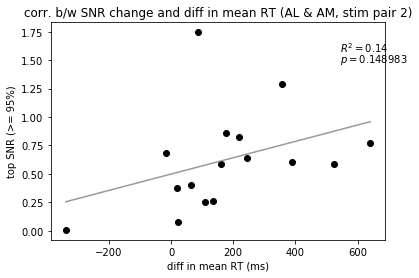

In [338]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
stimB_top_Abar_list = []
animals = []

# if using limited number of sessions at ends

sessions_to_count = 2
for animal in sorted(stimB_RTs.keys()):
#     if animal not in ['AL1', 'AL13', 'AM2']: # in case you want to eliminate animals from the analysis
    if animal not in []:
        animals.append(animal)
        stimB_top_Abar_list.append(stimB_top_Abar[animal]['mean_top_perf'])
        stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    else:
        pass

diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)
learningspeed = stimB_top_Abar_list # units are fraction per session (fraction being performance from 0 to 1)
# learningspeed = [i*100 for i in stimB_learningspeedlist] # convert to percent


# 1-D polynomial fit, e.g. linear regression
x = diffs
y = learningspeed

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(diffs, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

# plt.ylim(0, 0.15)
# plt.xlim(-400, 800)
plt.xlabel('diff in mean RT (ms)')
plt.ylabel('top SNR (>= 95%)')
plt.title('corr. b/w SNR change and diff in mean RT (AL & AM, stim pair 2)')
# plt.savefig('AL_AM_Cohorts_SNR_change_first3sessions_v_diff_in_RT_stimB.pdf')

In [335]:
# linear regression SNR across sessions

data_dict = stimB_Abar

# if want a specific subset of sessions
sessions_to_count = 2

fit_dict = {}
for key in data_dict.keys():
    # turn x-axis into sessions based on index of performance data
    x = [i+1 for i in range(len(data_dict[key][:sessions_to_count]))]
    y = data_dict[key][:sessions_to_count]
    
    # 1-D polynomial fit, e.g. linear regression
    par = np.polyfit(x, y, 1, full=True)
    
    slope = par[0][0]
    intercept = [par][0][1]
    # make line of best fit ('lobf')
    x_of_lobf = [min(x), max(x)]
    y_of_lobf = [slope*xx + intercept  for xx in x_of_lobf]
    
    fit_data = {
        'slope': slope,
        'intercept': intercept,
        'x_of_lobf': x_of_lobf,
        'y_of_lobf': y_of_lobf
    }
    
    fit_dict[key] = fit_data
    

stimB_Abar_learningspeed = fit_dict

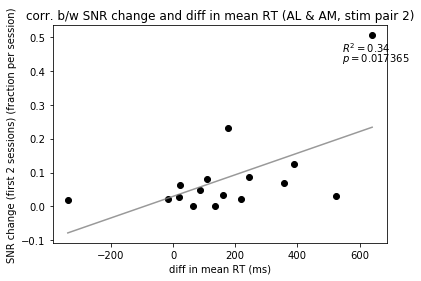

In [336]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
stimB_Abar_learningspeedlist = []
animals = []

# if using limited number of sessions at ends

sessions_to_count = 2
for animal in sorted(stimB_RTs.keys()):
#     if animal not in ['AL1', 'AL13', 'AM2']: # in case you want to eliminate animals from the analysis
    if animal not in []:
        animals.append(animal)
        stimB_Abar_learningspeedlist.append(stimB_Abar_learningspeed[animal]['slope'])
        stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    else:
        pass

diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)
learningspeed = stimB_Abar_learningspeedlist # units are fraction per session (fraction being performance from 0 to 1)
# learningspeed = [i*100 for i in stimB_learningspeedlist] # convert to percent


# 1-D polynomial fit, e.g. linear regression
x = diffs
y = learningspeed

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(diffs, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

# plt.ylim(0, 0.15)
# plt.xlim(-400, 800)
plt.xlabel('diff in mean RT (ms)')
plt.ylabel('SNR change (first 2 sessions) (fraction per session)')
plt.title('corr. b/w SNR change and diff in mean RT (AL & AM, stim pair 2)')
# plt.savefig('AL_AM_Cohorts_SNR_change_first3sessions_v_diff_in_RT_stimB.pdf')

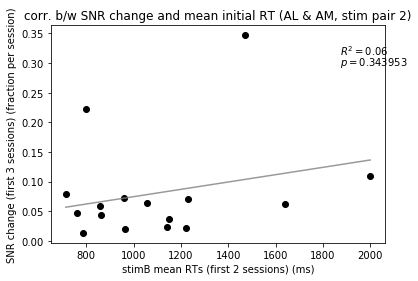

In [41]:
stimB_mean_RTs = []
fullcross_mean_RTs = []
stimB_Abar_learningspeedlist = []
animals = []

# if using limited number of sessions at ends

sessions_to_count = 2
for animal in sorted(stimB_RTs.keys()):
#     if animal not in ['AL1', 'AL13', 'AM2']: # in case you want to eliminate animals from the analysis
    if animal not in []:
        animals.append(animal)
        stimB_Abar_learningspeedlist.append(stimB_Abar_learningspeed[animal]['slope'])
        stimB_mean_RTs.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
        fullcross_mean_RTs.append(np.mean(fullcross_RTs[animal][-sessions_to_count:]))
    else:
        pass

diffs = np.subtract(stimB_mean_RTs, fullcross_mean_RTs)
learningspeed = stimB_Abar_learningspeedlist # units are fraction per session (fraction being performance from 0 to 1)
# learningspeed = [i*100 for i in stimB_learningspeedlist] # convert to percent


# 1-D polynomial fit, e.g. linear regression
x = stimB_mean_RTs
y = learningspeed

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))


plt.plot(stimB_mean_RTs, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

# plt.ylim(0, 0.15)
# plt.xlim(-400, 800)
plt.xlabel('stimB mean RTs (first 2 sessions) (ms)')
plt.ylabel('SNR change (first 3 sessions) (fraction per session)')
plt.title('corr. b/w SNR change and mean initial RT (AL & AM, stim pair 2)')
# plt.savefig('AL_AM_Cohorts_SNR_change_first3sessions_v_mean_initial_RT_stimB.pdf')

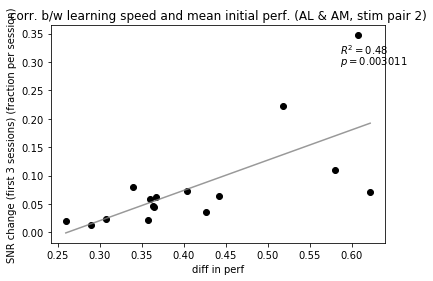

In [42]:
perf_diff = []
sessions_to_count = 2
for animal in sorted(stimB_perf.keys()):
    perf_diff.append(np.mean(fullcross_perf[animal][-sessions_to_count:]) - np.mean(stimB_perf[animal][:sessions_to_count]))

    
# 1-D polynomial fit, e.g. linear regression
x = perf_diff
y = learningspeed

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

# plt.ylim(0, 0.15)
# plt.xlim(-400, 800)
plt.xlabel('diff in perf')
plt.ylabel('SNR change (first 3 sessions) (fraction per session)')
plt.title('corr. b/w learning speed and mean initial perf. (AL & AM, stim pair 2)')
# plt.savefig('AL_AM_Cohorts_SNR_change_first3sessions_v_diff_in_perf_stimB.pdf')

# Post-error slowing

In [9]:
# function that finds and classifies RTs for trials after correct and error trials

def post_error_or_correct_RTs(dataset_of_interest):
    postoutcome_RTs = {}
    for animal in sorted(dataset_of_interest.keys()):
        posterr_corr_RT_by_session = {}
        postcorr_corr_RT_by_session = {}
        posterr_err_RT_by_session = {}
        postcorr_err_RT_by_session = {}
        for session in sorted(dataset_of_interest[animal]['beh_outcome_by_session'].keys()):
            posterr_corr_RT = []
            postcorr_corr_RT = []
            posterr_err_RT = []
            postcorr_err_RT = []
            for i in range(len(dataset_of_interest[animal]['beh_outcome_by_session'][session])):
                if i == 0: # skip first one because looking at i and i-1
                    pass
                else:
                    past_outcome = dataset_of_interest[animal]['beh_outcome_by_session'][session][i-1]
                    curr_outcome = dataset_of_interest[animal]['beh_outcome_by_session'][session][i]
                    if curr_outcome == 'success':
                        if past_outcome == 'failure':
                            posterr_corr_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        elif past_outcome == 'success':
                            postcorr_corr_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        else:
                            pass
                    elif curr_outcome == 'failure':
                        if past_outcome == 'failure':
                            posterr_err_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        elif past_outcome == 'success':
                            postcorr_err_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        else:
                            pass
                    else:
                        pass

            posterr_corr_RT_by_session[session] = posterr_corr_RT
            postcorr_corr_RT_by_session[session] = postcorr_corr_RT
            posterr_err_RT_by_session[session] = posterr_err_RT
            postcorr_err_RT_by_session[session] = postcorr_err_RT

        postoutcome_RTs[animal] = {
            'posterr_corr_RTs': posterr_corr_RT_by_session,
            'postcorr_corr_RTs': postcorr_corr_RT_by_session,
            'posterr_err_RTs': posterr_err_RT_by_session,
            'postcorr_err_RTs': postcorr_err_RT_by_session}

    return postoutcome_RTs

In [10]:
postoutcome_RTs = post_error_or_correct_RTs(results_stimB_base)

In [11]:
postoutcome_RTs_stimB = post_error_or_correct_RTs(results_stimB)

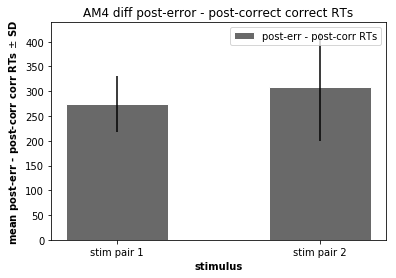

In [34]:
diff_mean_regstim_all = []
diff_mean_stimB_all = []
diff_mean_regstim_all_dict = {}
diff_mean_stimB_all_dict = {}
diff_mean_stimB_minus_regstim_all_dict = {}

for animal in sorted(postoutcome_RTs.keys()):
    
    sessions_to_count = 2
    
    # ~~~~~~collecting individual animal data~~~~~~~~
    data_regstim_postcorr_corr = []
    data_regstim_postcorr_corr_mean = []
    data_regstim_posterr_corr = []
    data_regstim_posterr_corr_mean = []
    for session in sorted(postoutcome_RTs[animal]['postcorr_corr_RTs'].keys())[-sessions_to_count:]:
        data_regstim_postcorr_corr.append(postoutcome_RTs[animal]['postcorr_corr_RTs'][session])
        data_regstim_postcorr_corr_mean.append(np.mean(postoutcome_RTs[animal]['postcorr_corr_RTs'][session]))
        data_regstim_posterr_corr.append(postoutcome_RTs[animal]['posterr_corr_RTs'][session])
        data_regstim_posterr_corr_mean.append(np.mean(postoutcome_RTs[animal]['posterr_corr_RTs'][session]))

    mean_regstim_postcorr_corr = np.nanmean(data_regstim_postcorr_corr_mean)
    std_regstim_postcorr_corr = np.nanstd(data_regstim_postcorr_corr_mean)
    mean_regstim_posterr_corr = np.nanmean(data_regstim_posterr_corr_mean)
    std_regstim_posterr_corr = np.nanstd(data_regstim_posterr_corr_mean)

    sessions_to_count = 2

    data_stimB_postcorr_corr = []
    data_stimB_postcorr_corr_mean = []
    data_stimB_posterr_corr = []
    data_stimB_posterr_corr_mean = []
    for session in sorted(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'].keys())[:sessions_to_count]:
        data_stimB_postcorr_corr.append(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'][session])
        data_stimB_postcorr_corr_mean.append(np.mean(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'][session]))
        data_stimB_posterr_corr.append(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'][session])
        data_stimB_posterr_corr_mean.append(np.mean(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'][session]))

    mean_stimB_postcorr_corr = np.nanmean(data_stimB_postcorr_corr_mean)
    std_stimB_postcorr_corr = np.nanstd(data_stimB_postcorr_corr_mean)
    mean_stimB_posterr_corr = np.nanmean(data_stimB_posterr_corr_mean)
    std_stimB_posterr_corr = np.nanstd(data_stimB_posterr_corr_mean)
    
    diff_mean_regstim = mean_regstim_posterr_corr - mean_regstim_postcorr_corr
    diff_mean_regstim_all.append(diff_mean_regstim)
    diff_mean_regstim_all_dict[animal] = diff_mean_regstim
    diff_mean_regstim_err = math.sqrt(std_regstim_posterr_corr**2 + std_regstim_postcorr_corr**2) # error of difference is addition in quadrature
    
    diff_mean_stimB = mean_stimB_posterr_corr - mean_stimB_postcorr_corr
    diff_mean_stimB_all.append(diff_mean_stimB)
    diff_mean_stimB_all_dict[animal] = diff_mean_stimB
    diff_mean_stimB_err = math.sqrt(std_stimB_posterr_corr**2 + std_stimB_postcorr_corr**2) # error of difference is addition in quadrature

    diff_mean_stimB_minus_regstim_all_dict[animal] = diff_mean_stimB - diff_mean_regstim
    
    
    # ~~~~~~plotting individual animal bar plots~~~~~~~~

    # set width of bar
    barWidth = 0.25   

    # set height of bar
    bars1 = [mean_regstim_posterr_corr, mean_stimB_posterr_corr]
    bars2 = [mean_regstim_postcorr_corr, mean_stimB_postcorr_corr]

    # set bar error
    err1 = [std_regstim_posterr_corr, std_stimB_posterr_corr]
    err2 = [std_regstim_postcorr_corr, std_stimB_postcorr_corr]

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    # r3 = [x + barWidth for x in r2]

    # Close previous plots
    plt.close()
    
    # Make the plot
    plt.bar(r1, bars1, yerr = err1, color='tomato', width=barWidth, edgecolor='white', label='post-error corr')
    plt.bar(r2, bars2, yerr = err2, color='dodgerblue', width=barWidth, edgecolor='white', label='post-corr corr')
    # plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')

    # Add xticks on the middle of the group bars
    plt.xlabel('stimulus', fontweight='bold')
    plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['stim pair 1', 'stim pair 2'])
    plt.ylabel('mean RT $\pm$ SD', fontweight = 'bold')

    plt.title('%s correct trial RTs after error or correct trial' %animal)

    # Create legend & Save graphic
    plt.legend()
#     plt.savefig('_graphs_stimpair2/%s_corr_RTs_post_err_or_corr_stimpair2.pdf' %animal)
    
    # ~~~~~~plotting individual animal bar plots of differences ~~~~~~~~

    # set width of bar
    barWidth = 0.5   

    # set height of bar
    bars1 = [diff_mean_regstim, diff_mean_stimB]
#     bars2 = [mean_regstim_postcorr_corr, mean_stimB_postcorr_corr]

    # set bar error
    err1 = [diff_mean_regstim_err, diff_mean_stimB_err]
#     err2 = [std_regstim_postcorr_corr, std_stimB_postcorr_corr]

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
#     r2 = [x + barWidth for x in r1]
    # r3 = [x + barWidth for x in r2]

    # Close previous plots
    plt.close()
    
    # Make the plot
    plt.bar(r1, bars1, yerr = err1, color='dimgrey', width=barWidth, edgecolor='white', label='post-err - post-corr RTs')
#     plt.bar(r2, bars2, yerr = err2, color='dodgerblue', width=barWidth, edgecolor='white', label='post-corr corr')
    # plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')

    # Add xticks on the middle of the group bars
    plt.xlabel('stimulus', fontweight='bold')
    plt.xticks([r for r in range(len(bars1))], ['stim pair 1', 'stim pair 2'])
    plt.ylabel('mean post-err - post-corr corr RTs $\pm$ SD', fontweight = 'bold')

    plt.title('%s diff post-error - post-correct correct RTs' %animal)

    # Create legend & Save graphic
    plt.legend()
#     plt.savefig('_graphs_stimpair2/%s_diff_corr_RTs_post_err_or_corr_stimpair2.pdf' %animal)

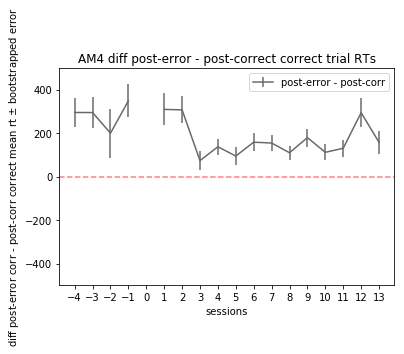

In [13]:
diff_mean_regstim_all_animals = []
diff_mean_stimB_all_animals = []

for animal in sorted(postoutcome_RTs.keys()):
    
    btstrp_iter = 100
    
    # ~~~~~~collecting individual animal data~~~~~~~~
    
    sessions_to_count_regstim = 4
    
    data_regstim_postcorr_corr_mean = average_data_rt(postoutcome_RTs[animal]['postcorr_corr_RTs']) # dictionary
    data_regstim_postcorr_corr_err = bootstrap_error_rt(postoutcome_RTs[animal]['postcorr_corr_RTs'], btstrp_iter) # dictionary
    data_regstim_posterr_corr_mean = average_data_rt(postoutcome_RTs[animal]['posterr_corr_RTs']) # dictionary
    data_regstim_posterr_corr_err = bootstrap_error_rt(postoutcome_RTs[animal]['posterr_corr_RTs'], btstrp_iter) # dictionary
    
    data_regstim_postcorr_corr = []
    data_regstim_posterr_corr = []
    session_mean_regstim_postcorr_corr = []
    session_err_regstim_postcorr_corr = []
    session_mean_regstim_posterr_corr = []
    session_err_regstim_posterr_corr = []
    session_diff_mean_regstim = []
    session_diff_err_regstim = []
    for session in sorted(postoutcome_RTs[animal]['postcorr_corr_RTs'].keys())[-sessions_to_count_regstim:]:
        # post-error correct
        data_regstim_posterr_corr.append(postoutcome_RTs[animal]['posterr_corr_RTs'][session]) # capture session values in order
        session_mean_regstim_posterr_corr.append(data_regstim_posterr_corr_mean[session]) # convert to list where sessions in order
        session_err_regstim_posterr_corr.append(data_regstim_posterr_corr_err[session]) # convert to list where sessions in order
        # post-correct correct
        data_regstim_postcorr_corr.append(postoutcome_RTs[animal]['postcorr_corr_RTs'][session]) # capture session values in order
        session_mean_regstim_postcorr_corr.append(data_regstim_postcorr_corr_mean[session]) # convert to list where sessions in order
        session_err_regstim_postcorr_corr.append(data_regstim_postcorr_corr_err[session])# convert to list where sessions in order
        # difference post-error correct - post-correct correct
        session_diff_mean_regstim.append(data_regstim_posterr_corr_mean[session] - data_regstim_postcorr_corr_mean[session])
        session_diff_err_regstim.append(math.sqrt(data_regstim_posterr_corr_err[session]**2 + data_regstim_postcorr_corr_err[session]**2)) # error of difference is addition in quadrature

    sessions_to_count_stimB = 13

    data_stimB_postcorr_corr_mean = average_data_rt(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'])
    data_stimB_postcorr_corr_err = bootstrap_error_rt(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'], btstrp_iter)
    data_stimB_posterr_corr_mean = average_data_rt(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'])
    data_stimB_posterr_corr_err = bootstrap_error_rt(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'], btstrp_iter)
    
    data_stimB_postcorr_corr = []
    data_stimB_posterr_corr = []
    session_mean_stimB_postcorr_corr = []
    session_err_stimB_postcorr_corr = []
    session_mean_stimB_posterr_corr = []
    session_err_stimB_posterr_corr = []
    session_diff_mean_stimB = []
    session_diff_err_stimB = []
    for session in sorted(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'].keys())[:sessions_to_count_stimB]:
        # post-error correct
        data_stimB_posterr_corr.append(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'][session])
        session_mean_stimB_posterr_corr.append(data_stimB_posterr_corr_mean[session])
        session_err_stimB_posterr_corr.append(data_stimB_posterr_corr_err[session])
        # post-correct correct
        data_stimB_postcorr_corr.append(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'][session])
        session_mean_stimB_postcorr_corr.append(data_stimB_postcorr_corr_mean[session])
        session_err_stimB_postcorr_corr.append(data_stimB_postcorr_corr_err[session])
        # difference post-error correct - post-correct correct
        session_diff_mean_stimB.append(data_stimB_posterr_corr_mean[session] - data_stimB_postcorr_corr_mean[session])
        session_diff_err_stimB.append(math.sqrt(data_stimB_posterr_corr_err[session]**2 + data_stimB_postcorr_corr_err[session]**2))

        
    # add to list for all animals
    diff_mean_regstim_all_animals.append(session_diff_mean_regstim)
    diff_mean_stimB_all_animals.append(session_diff_err_stimB)
    
    # take overall means of all sessions
    mean_regstim_postcorr_corr = np.nanmean(data_regstim_postcorr_corr_mean.values())
    std_regstim_postcorr_corr = np.nanstd(data_regstim_postcorr_corr_mean.values())
    mean_regstim_posterr_corr = np.nanmean(data_regstim_posterr_corr_mean.values())
    std_regstim_posterr_corr = np.nanstd(data_regstim_posterr_corr_mean.values())
    mean_stimB_postcorr_corr = np.nanmean(data_stimB_postcorr_corr_mean.values())
    std_stimB_postcorr_corr = np.nanstd(data_stimB_postcorr_corr_mean.values())
    mean_stimB_posterr_corr = np.nanmean(data_stimB_posterr_corr_mean.values())
    std_stimB_posterr_corr = np.nanstd(data_stimB_posterr_corr_mean.values())
    # find differences between post-error correct and post-correct correct across all sessions
#     diff_mean_regstim = mean_regstim_posterr_corr - mean_regstim_postcorr_corr
#     diff_mean_regstim_all.append(diff_mean_regstim)
#     diff_mean_regstim_err = math.sqrt(std_regstim_posterr_corr**2 + std_regstim_postcorr_corr**2) # error of difference is addition in quadrature
#     diff_mean_stimB = mean_stimB_posterr_corr - mean_stimB_postcorr_corr
#     diff_mean_stimB_all.append(diff_mean_stimB)
#     diff_mean_stimB_err = math.sqrt(std_stimB_posterr_corr**2 + std_stimB_postcorr_corr**2) # error of difference is addition in quadrature

    # ~~~~~~plotting individual animal classified RTs~~~~~~~~                                

    x = [i - sessions_to_count_regstim for i in range(len(session_mean_regstim_posterr_corr + [np.nan] + session_mean_stimB_posterr_corr))]
    y1 = session_mean_regstim_posterr_corr + [np.nan] + session_mean_stimB_posterr_corr
    y2 = session_mean_regstim_postcorr_corr + [np.nan] + session_mean_stimB_postcorr_corr
    
    y1err = session_err_regstim_posterr_corr + [np.nan] + session_err_stimB_posterr_corr
    y2err = session_err_regstim_postcorr_corr + [np.nan] + session_err_stimB_postcorr_corr
    
    plt.close()
    plt.errorbar(x = x, y = y1, yerr = y1err, color = 'tomato', label = 'post-error corr')
    plt.errorbar(x = x, y = y2, yerr = y2err, color = 'dodgerblue', label = 'post-corr corr')
    plt.xlabel('sessions')
    plt.xticks(x)
    plt.ylabel('rt $\pm$ bootstrapped error')
    plt.title('%s correct trial RTs after error or correct trial' %animal)
    plt.legend()
#     plt.savefig('_graphs_stimpair2/by_session/%s_corr_RTs_post_err_or_corr_by_session_stimpair2.pdf' %animal)
                                      
    # ~~~~~~plotting individual animal differences~~~~~~~~  
    
    x = [i - sessions_to_count_regstim for i in range(len(session_mean_regstim_posterr_corr + [np.nan] + session_mean_stimB_posterr_corr))]
    y1 = session_diff_mean_regstim + [np.nan] + session_diff_mean_stimB
    
    y1err = session_diff_err_regstim + [np.nan] + session_diff_err_stimB
    
    plt.close()
    plt.errorbar(x = x, y = y1, yerr = y1err, color = 'dimgrey', label = 'post-error - post-corr')
    plt.axhline(y = 0, color = 'r', linestyle = '--', alpha = 0.5)
    plt.xlabel('sessions')
    plt.xticks(x)
    plt.ylim(-500,500)
    plt.ylabel('diff post-error corr - post-corr correct mean rt $\pm$ bootstrapped error')
    plt.title('%s diff post-error - post-correct correct trial RTs' %animal)
    plt.legend()
#     plt.savefig('_graphs_stimpair2/by_session/%s_diff_corr_RTs_post_err_or_corr_by_session_stimpair2.pdf' %animal) 

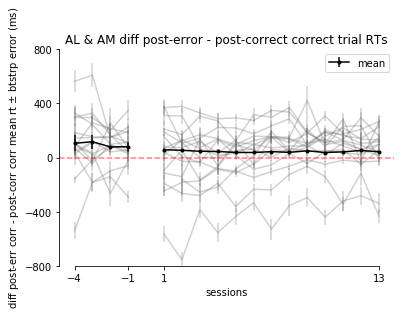

In [55]:
diff_mean_regstim_all_animals = []
diff_mean_stimB_all_animals = []

for animal in sorted(postoutcome_RTs.keys()):
    
    btstrp_iter = 100
    
    # ~~~~~~collecting individual animal data~~~~~~~~
    
    sessions_to_count_regstim = 4
    
    data_regstim_postcorr_corr_mean = average_data_rt(postoutcome_RTs[animal]['postcorr_corr_RTs']) # dictionary
    data_regstim_postcorr_corr_err = bootstrap_error_rt(postoutcome_RTs[animal]['postcorr_corr_RTs'], btstrp_iter) # dictionary
    data_regstim_posterr_corr_mean = average_data_rt(postoutcome_RTs[animal]['posterr_corr_RTs']) # dictionary
    data_regstim_posterr_corr_err = bootstrap_error_rt(postoutcome_RTs[animal]['posterr_corr_RTs'], btstrp_iter) # dictionary
    
    data_regstim_postcorr_corr = []
    data_regstim_posterr_corr = []
    session_mean_regstim_postcorr_corr = []
    session_err_regstim_postcorr_corr = []
    session_mean_regstim_posterr_corr = []
    session_err_regstim_posterr_corr = []
    session_diff_mean_regstim = []
    session_diff_err_regstim = []
    for session in sorted(postoutcome_RTs[animal]['postcorr_corr_RTs'].keys())[-sessions_to_count_regstim:]:
        # post-error correct
        data_regstim_posterr_corr.append(postoutcome_RTs[animal]['posterr_corr_RTs'][session]) # capture session values in order
        session_mean_regstim_posterr_corr.append(data_regstim_posterr_corr_mean[session]) # convert to list where sessions in order
        session_err_regstim_posterr_corr.append(data_regstim_posterr_corr_err[session]) # convert to list where sessions in order
        # post-correct correct
        data_regstim_postcorr_corr.append(postoutcome_RTs[animal]['postcorr_corr_RTs'][session]) # capture session values in order
        session_mean_regstim_postcorr_corr.append(data_regstim_postcorr_corr_mean[session]) # convert to list where sessions in order
        session_err_regstim_postcorr_corr.append(data_regstim_postcorr_corr_err[session])# convert to list where sessions in order
        # difference post-error correct - post-correct correct
        session_diff_mean_regstim.append(data_regstim_posterr_corr_mean[session] - data_regstim_postcorr_corr_mean[session])
        session_diff_err_regstim.append(math.sqrt(data_regstim_posterr_corr_err[session]**2 + data_regstim_postcorr_corr_err[session]**2)) # error of difference is addition in quadrature

    sessions_to_count_stimB = 13

    data_stimB_postcorr_corr_mean = average_data_rt(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'])
    data_stimB_postcorr_corr_err = bootstrap_error_rt(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'], btstrp_iter)
    data_stimB_posterr_corr_mean = average_data_rt(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'])
    data_stimB_posterr_corr_err = bootstrap_error_rt(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'], btstrp_iter)
    
    data_stimB_postcorr_corr = []
    data_stimB_posterr_corr = []
    session_mean_stimB_postcorr_corr = []
    session_err_stimB_postcorr_corr = []
    session_mean_stimB_posterr_corr = []
    session_err_stimB_posterr_corr = []
    session_diff_mean_stimB = []
    session_diff_err_stimB = []
    for session in sorted(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'].keys())[:sessions_to_count_stimB]:
        # post-error correct
        data_stimB_posterr_corr.append(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'][session])
        session_mean_stimB_posterr_corr.append(data_stimB_posterr_corr_mean[session])
        session_err_stimB_posterr_corr.append(data_stimB_posterr_corr_err[session])
        # post-correct correct
        data_stimB_postcorr_corr.append(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'][session])
        session_mean_stimB_postcorr_corr.append(data_stimB_postcorr_corr_mean[session])
        session_err_stimB_postcorr_corr.append(data_stimB_postcorr_corr_err[session])
        # difference post-error correct - post-correct correct
        session_diff_mean_stimB.append(data_stimB_posterr_corr_mean[session] - data_stimB_postcorr_corr_mean[session])
        session_diff_err_stimB.append(math.sqrt(data_stimB_posterr_corr_err[session]**2 + data_stimB_postcorr_corr_err[session]**2))

        
    # add to list for all animals
    diff_mean_regstim_all_animals.append(session_diff_mean_regstim)
    diff_mean_stimB_all_animals.append(session_diff_err_stimB)
    
    # take overall means of all sessions
    mean_regstim_postcorr_corr = np.nanmean(data_regstim_postcorr_corr_mean.values())
    std_regstim_postcorr_corr = np.nanstd(data_regstim_postcorr_corr_mean.values())
    mean_regstim_posterr_corr = np.nanmean(data_regstim_posterr_corr_mean.values())
    std_regstim_posterr_corr = np.nanstd(data_regstim_posterr_corr_mean.values())
    mean_stimB_postcorr_corr = np.nanmean(data_stimB_postcorr_corr_mean.values())
    std_stimB_postcorr_corr = np.nanstd(data_stimB_postcorr_corr_mean.values())
    mean_stimB_posterr_corr = np.nanmean(data_stimB_posterr_corr_mean.values())
    std_stimB_posterr_corr = np.nanstd(data_stimB_posterr_corr_mean.values())
    # find differences between post-error correct and post-correct correct across all sessions
#     diff_mean_regstim = mean_regstim_posterr_corr - mean_regstim_postcorr_corr
# #     diff_mean_regstim_all.append(diff_mean_regstim)
#     diff_mean_regstim_err = math.sqrt(std_regstim_posterr_corr**2 + std_regstim_postcorr_corr**2) # error of difference is addition in quadrature
#     diff_mean_stimB = mean_stimB_posterr_corr - mean_stimB_postcorr_corr
# #     diff_mean_stimB_all.append(diff_mean_stimB)
#     diff_mean_stimB_err = math.sqrt(std_stimB_posterr_corr**2 + std_stimB_postcorr_corr**2) # error of difference is addition in quadrature
    
    # ~~~~~~plotting individual animal differences~~~~~~~~  
    
    x = [i - sessions_to_count_regstim for i in range(len(session_mean_regstim_posterr_corr + [np.nan] + session_mean_stimB_posterr_corr))]
    y1 = session_diff_mean_regstim + [np.nan] + session_diff_mean_stimB
    
    y1err = session_diff_err_regstim + [np.nan] + session_diff_err_stimB
    
    plt.errorbar(x = x, y = y1, yerr = y1err, color = 'dimgrey', alpha = 0.3)


regstimmean = np.nanmean(diff_mean_regstim_all_animals, axis = 0)
stimBmean = np.nanmean(diff_mean_stimB_all_animals, axis = 0)

# regstimerr = np.nanstd(diff_mean_regstim_all_animals, axis = 0) / len(diff_mean_regstim_all_animals)
# stimBerr = np.nanstd(diff_mean_stimB_all_animals, axis = 0) / len(diff_mean_stimB_all_animals)

regstimerr = stats.sem(diff_mean_regstim_all_animals, axis = 0)
stimBerr = stats.sem(diff_mean_stimB_all_animals, axis = 0) 

y = np.concatenate((regstimmean, np.array([np.nan]), stimBmean))
x = [i - 4 for i in range(len(y))]

yerr = np.concatenate((regstimerr, np.array([np.nan]), stimBerr))


plt.errorbar(x = x, y = y, yerr = yerr, color = 'k', marker = '.', label = 'mean')
plt.axhline(y = 0, color = 'r', linestyle = '--', alpha = 0.5)
plt.xlabel('sessions')
plt.xticks([-4, -1, 1, 13])
plt.ylabel('diff post-err corr - post-corr corr mean rt $\pm$ btstrp error (ms)')
plt.ylim(-800,800)
plt.yticks([-800, -400, 0, 400, 800])
# plt.ylim(-100,200)
# plt.yticks([-100, 0, 100, 200])
plt.title('AL & AM diff post-error - post-correct correct trial RTs')
plt.legend()
sns.despine(trim = True)
plt.savefig('_graphs_stimpair2/posterror_RTs/by_session/AL_AM_corr_RTs_post_err_or_corr_by_session_stimpair2.pdf')
# plt.savefig('_graphs_stimpair2/posterror_RTs/by_session/AL_AM_mean_corr_RTs_post_err_or_corr_by_session_stimpair2.pdf')

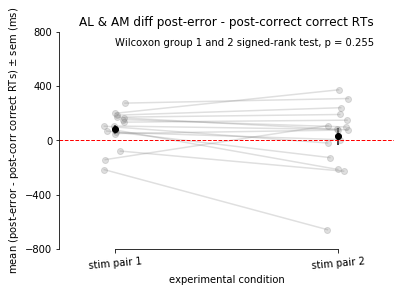

In [51]:
diff_mean_regstim_all
diff_mean_stimB_all

x_means = [0,1]
y_means = [np.mean(diff_mean_regstim_all), np.mean(diff_mean_stimB_all)]
y_means_err = [stats.sem(diff_mean_regstim_all), stats.sem(diff_mean_stimB_all)]

# plot the individual animal averages first, in gray
for i in range(len(diff_mean_regstim_all)):
    jiggle = np.random.uniform(-0.05, 0.05) # create some random noise
    x = [0+jiggle, 1+jiggle] # add that noise to the dot locations so they don't exactly overlap
    y = [diff_mean_regstim_all[i], diff_mean_stimB_all[i]]
    plt.plot(x, y, marker = 'o', color = 'gray', linestyle = '-', alpha = 0.25)

# plot the mean of the animals' individual averages, and add the error bars
labels = ['stim pair 1', 'stim pair 2']

plt.errorbar(x_means, y_means, yerr = y_means_err, marker = 'o', linestyle = ' ', color = 'black')
plt.xlim(-.25, 1.25)
plt.ylim(-800, 800)
plt.yticks([-800, -400, 0, 400, 800])
plt.axhline(y = 0, linestyle = '--', color = 'r', linewidth = 1)

plt.xticks(x_means, labels, rotation=5)

# plt.ylabel('average RT (ms), mean $\pm$ sem')
plt.ylabel('mean (post-error - post-corr correct RTs) $\pm$ sem (ms)')
plt.xlabel('experimental condition')
plt.title('AL & AM diff post-error - post-correct correct RTs')

# Wilcoxon rank-sum test tests whether two groups are sampled from the same distribution
# intended for independent samples
# s = 'Wilcoxon group 1 and 2 rank-sum test, p = %.3f'  % stats.ranksums(diff_mean_regstim_all, diff_mean_stimB_all)[1]

# Wilcoxon signed-rank test tests whether distribution of differences is symmetric about zero
# intended for paired samples
s = 'Wilcoxon group 1 and 2 signed-rank test, p = %.3f'  % stats.wilcoxon(diff_mean_regstim_all, diff_mean_stimB_all)[1]
plt.text(0, 700, s)

sns.despine(trim = True)
plt.savefig('_graphs_stimpair2/posterror_RTs/AL_AM_diff_corr_RTs_post_err_or_corr_last2sesh_of_stimpair1_first2sesh_of_stimpair2.pdf')

In [31]:
diff_mean_stimB_all

[-18.909308395625885,
 -656.6019973611692,
 -126.08251630591622,
 190.98908398684648,
 5.985570142331426,
 77.7301323287927,
 81.1765901251091,
 75.99854715822732,
 372.590420823012,
 149.14002192249063,
 240.90349168090802,
 -226.23848696882033,
 -213.3714931282824,
 109.3686923076923,
 99.22393659061254,
 308.59813252772426]

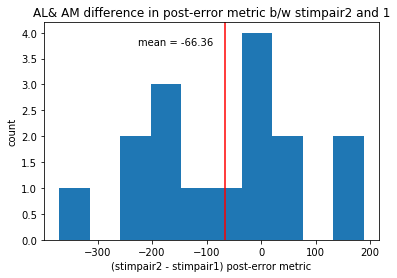

In [327]:
diff_mean_stimB_minus_regstim_all_dict

y = diff_mean_stimB_minus_regstim_all_dict.values()

plt.hist(y)
plt.text(-225, 3.75, 'mean = %.2f'% np.mean(y))
plt.xlabel('(stimpair2 - stimpair1) post-error metric')
plt.ylabel('count')
plt.title('AL& AM difference in post-error metric b/w stimpair2 and 1')
plt.axvline(np.mean(y), color = 'r')
plt.savefig('_graphs_stimpair2/posterror_RTs/AL_AM_diff_post-error_metric_first2sesh_of_stimpair2_and_last4sesh_stimpair1.pdf')

0.0484


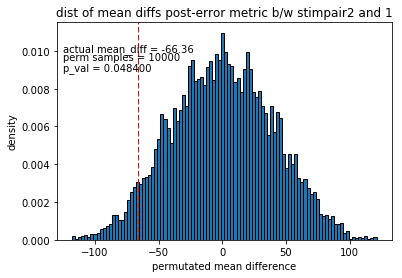

In [328]:
diffs = diff_mean_stimB_minus_regstim_all_dict.values()

nreps = 10000

means = []
for i in range(nreps):
    sign_dist = [random.choice([-1, 1]) for i in range(len(diffs))]
    perm = np.multiply(diffs, sign_dist)
    perm_mean = np.mean(perm)
    means.append(perm_mean)
    
hits = 0
for i in means:
    if i < np.mean(diffs):
        hits += 1
    else:
        pass

p_val = hits/len(means)

print p_val


plt.hist(means, bins = 100, normed = True, edgecolor = 'k')
plt.axvline(np.mean(diffs), color='r', linestyle='dashed', linewidth=1)
plt.ylabel('density')
plt.xlabel('permutated mean difference')
plt.title('dist of mean diffs post-error metric b/w stimpair2 and 1')
plt.text(-125, 0.010, 'actual mean_diff = %.2f'% np.mean(diffs))
plt.text(-125, 0.0095, 'perm samples = %i' % nreps)
plt.text(-125, 0.009, 'p_val = %f' % p_val)
plt.savefig('_graphs_stimpair2/posterror_RTs/AL_AM_significance_of_mean_diff_post-error_metric_first2sesh_of_stimpair2_and_last4sesh_stimpair1.pdf')

### correlation between learning speed and (post-error correct - post-correct correct RTs)

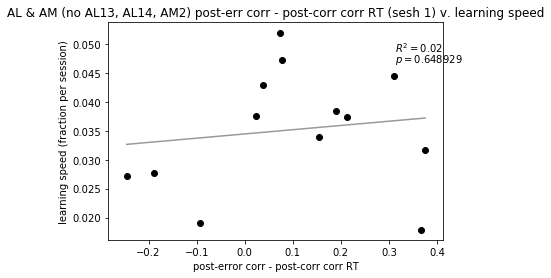

In [246]:
# diff_mean_regstim_all_dict = {}
# diff_mean_stimB_all_dict = {}

x = []
y = []
for animal in stimB_raw_RTs.keys():
    if animal not in ['AL13', 'AL14', 'AM2']: # AM2 has a NaN value
        # looking at first two sessions of stim B
        x.append(diff_mean_stimB_all_dict[animal])
        # learning speed till asymptitic performance
        y.append(stimB_learningspeed[animal]['slope'])

    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('post-error corr - post-corr corr RT')
plt.ylabel('learning speed (fraction per session)')
plt.title('AL & AM (no AL13, AL14, AM2) post-err corr - post-corr corr RT (sesh 1) v. learning speed')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_except_AL13_AL14_AM2_post-err_ratio_firstsesh_v_learningspeed_stimpair2.pdf')

### correlation between SNR change and (post-error correct - post-correct correct RTs)

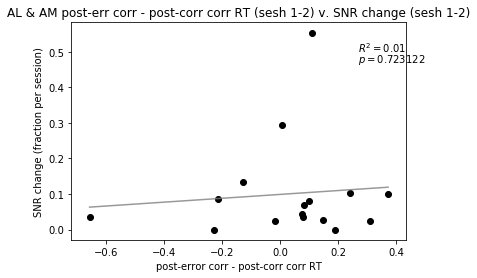

In [305]:
# diff_mean_regstim_all_dict = {}
# diff_mean_stimB_all_dict = {}

x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # AM2 has a NaN value
    if animal not in ['hello']:
        # looking at first two sessions of stim B
        x.append(diff_mean_stimB_all_dict[animal])
        # learning speed till asymptitic performance
        y.append(stimB_Abar_learningspeed[animal]['slope'])

    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('post-error corr - post-corr corr RT')
plt.ylabel('SNR change (fraction per session)')
plt.title('AL & AM post-err corr - post-corr corr RT (sesh 1-2) v. SNR change (sesh 1-2)')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_except_post-err_ratio_first2sesh_v_SNRchange_first2sesh_stimpair2.pdf')

In [240]:
diff_mean_stimB_all_dict

{'AL1': -92.951743576965782,
 'AL13': -562.59583855589494,
 'AL14': -112.7464437229437,
 'AL15': 212.07088737928734,
 'AL16': 38.212168398268318,
 'AL2': 23.947808690935972,
 'AL3': 154.12548663312964,
 'AL4': 77.399340691328121,
 'AL5': 367.5487844225886,
 'AL6': 189.06753448275856,
 'AL7': 375.37974115267934,
 'AL8': -189.5440040481833,
 'AM1': -245.53803648509745,
 'AM2': nan,
 'AM3': 73.177022112731947,
 'AM4': 309.71122472830757}

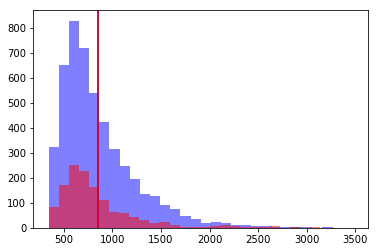

In [52]:
animal = 'AM1'

histdata2 = []
for session in sorted(postoutcome_RTs[animal]['postcorr_corr_RTs'].keys()):
    histdata2.extend(postoutcome_RTs[animal]['postcorr_corr_RTs'][session])

bins = 30
plt.hist(histdata2, bins = bins, alpha = 0.5, color = 'b')
plt.axvline(np.mean(histdata2), color = 'b')

histdata1 = []
for session in sorted(postoutcome_RTs[animal]['posterr_corr_RTs'].keys()):
    histdata1.extend(postoutcome_RTs[animal]['posterr_corr_RTs'][session])

bins = 30
plt.hist(histdata1, bins = bins, alpha = 0.5, color = 'r')
plt.axvline(np.mean(histdata1), color = 'r')

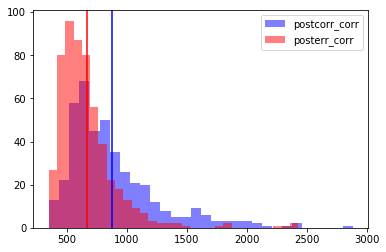

In [53]:
animal = 'AM1'

histdata2 = []
for session in sorted(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'].keys())[:2]:
    histdata2.extend(postoutcome_RTs_stimB[animal]['postcorr_corr_RTs'][session])

bins = 30
plt.hist(histdata2, bins = bins, alpha = 0.5, color = 'b', label = 'postcorr_corr')
plt.axvline(np.mean(histdata2), color = 'b')

histdata1 = []
for session in sorted(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'].keys())[:2]:
    histdata1.extend(postoutcome_RTs_stimB[animal]['posterr_corr_RTs'][session])

bins = 30
plt.hist(histdata1, bins = bins, alpha = 0.5, color = 'r', label = 'posterr_corr')
plt.axvline(np.mean(histdata1), color = 'r')

plt.legend()

# Total Viewing Time

In [197]:
# gather the RT data into dictionaries

stimB_raw_RTs = {}
stimB_raw_success_RTs = {}
stimB_raw_failure_RTs = {}
stimB_raw_RTs_sum = {}
stimB_raw_success_RTs_sum = {}
stimB_raw_success2500_RTs_sum = {}
stimB_raw_failure_RTs_sum = {}
stimB_raw_success2500_failure_RTs_sum = {} # stim stays on for 2.5 seconds (2500 ms) during correct trials; calculate total viewing time taking this into account

fullcross_raw_RTs = {}
fullcross_raw_success_RTs = {}
fullcross_raw_failure_RTs = {}
fullcross_raw_RTs_sum = {}
fullcross_raw_success_RTs_sum = {}
fullcross_raw_success2500_RTs_sum = {}
fullcross_raw_failure_RTs_sum = {}
fullcross_raw_success2500_failure_RTs_sum = {} # stim stays on for 2.5 seconds (2500 ms) during correct trials; calculate total viewing time taking this into account

for animal in results_stimB.iterkeys():
    for session in sorted(results_stimB[animal][relevant_data]):
        try:
            stimB_raw_RTs[animal].append(results_stimB[animal]['rt_by_session'][session])
            stimB_raw_RTs_sum[animal].append(sum(results_stimB[animal]['rt_by_session'][session]))
            stimB_raw_success_RTs[animal].append(results_stimB[animal]['rt_success_by_session'][session])
            stimB_raw_success_RTs_sum[animal].append(sum(results_stimB[animal]['rt_success_by_session'][session]))
            stimB_raw_success2500_RTs_sum[animal].append(2500*len(results_stimB[animal]['rt_success_by_session'][session]))
            stimB_raw_failure_RTs[animal].append(results_stimB[animal]['rt_failure_by_session'][session])
            stimB_raw_failure_RTs_sum[animal].append(sum(results_stimB[animal]['rt_failure_by_session'][session]))
            stimB_raw_success2500_failure_RTs_sum[animal].append(sum(results_stimB[animal]['rt_failure_by_session'][session]) + 2500*len(results_stimB[animal]['rt_success_by_session'][session]))
        except KeyError:
            stimB_raw_RTs[animal] = [results_stimB[animal]['rt_by_session'][session]]
            stimB_raw_RTs_sum[animal] = [sum(results_stimB[animal]['rt_by_session'][session])]
            stimB_raw_success_RTs[animal] = [results_stimB[animal]['rt_success_by_session'][session]]
            stimB_raw_success_RTs_sum[animal] = [sum(results_stimB[animal]['rt_success_by_session'][session])]
            stimB_raw_success2500_RTs_sum[animal] = [2500*len(results_stimB[animal]['rt_success_by_session'][session])]
            stimB_raw_failure_RTs[animal] = [results_stimB[animal]['rt_failure_by_session'][session]]
            stimB_raw_failure_RTs_sum[animal] = [sum(results_stimB[animal]['rt_failure_by_session'][session])]
            stimB_raw_success2500_failure_RTs_sum[animal] = [sum(results_stimB[animal]['rt_failure_by_session'][session]) + 2500*len(results_stimB[animal]['rt_success_by_session'][session])]

for animal in results_stimB_base.iterkeys():
    for session in sorted(results_stimB_base[animal][relevant_data]):
        try:
            fullcross_raw_RTs[animal].append(results_stimB_base[animal]['rt_by_session'][session])
            fullcross_raw_RTs_sum[animal].append(sum(results_stimB_base[animal]['rt_by_session'][session]))
            fullcross_raw_success_RTs[animal].append(results_stimB_base[animal]['rt_success_by_session'][session])
            fullcross_raw_success_RTs_sum[animal].append(sum(results_stimB_base[animal]['rt_success_by_session'][session]))
            fullcross_raw_success2500_RTs_sum[animal].append(2500*len(results_stimB_base[animal]['rt_success_by_session'][session]))
            fullcross_raw_failure_RTs[animal].append(results_stimB_base[animal]['rt_failure_by_session'][session])
            fullcross_raw_failure_RTs_sum[animal].append(sum(results_stimB_base[animal]['rt_failure_by_session'][session]))
            fullcross_raw_success2500_failure_RTs[animal].append(sum(results_stimB_base[animal]['rt_failure_by_session'][session]) + 2500*len(results_stimB_base[animal]['rt_success_by_session'][session]))
        except KeyError:
            fullcross_raw_RTs[animal] = [results_stimB_base[animal]['rt_by_session'][session]]
            fullcross_raw_RTs_sum[animal] = [sum(results_stimB_base[animal]['rt_by_session'][session])]
            fullcross_raw_success_RTs[animal] = [results_stimB_base[animal]['rt_success_by_session'][session]]
            fullcross_raw_success_RTs_sum[animal] = [sum(results_stimB_base[animal]['rt_success_by_session'][session])]
            fullcross_raw_success2500_RTs_sum[animal] = [2500*len(results_stimB_base[animal]['rt_success_by_session'][session])]
            fullcross_raw_failure_RTs[animal] = [results_stimB_base[animal]['rt_failure_by_session'][session]]
            fullcross_raw_failure_RTs_sum[animal] = [sum(results_stimB_base[animal]['rt_failure_by_session'][session])]
            fullcross_raw_success2500_failure_RTs[animal] = [sum(results_stimB_base[animal]['rt_failure_by_session'][session]) + 2500*len(results_stimB_base[animal]['rt_success_by_session'][session])]

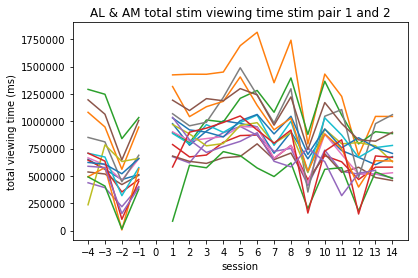

In [145]:
sessions_to_count_regstim = 4

for animal in stimB_raw_RTs_sum.keys():
#     plt.plot(stimB_raw_RTs_sum[i])
    y = fullcross_raw_RTs_sum[animal][-sessions_to_count_regstim:] + [np.nan] + stimB_raw_RTs_sum[animal]
    x = [i - sessions_to_count_regstim for i in range(len(y))]
    plt.plot(x, y)
    plt.xticks(x)
    plt.ylabel('total viewing time (ms)')
    plt.xlabel('session')
    plt.title('AL & AM total stim viewing time stim pair 1 and 2')
    plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_stimpair1_and_2.pdf')

### correlation between number of trials and total viewing time

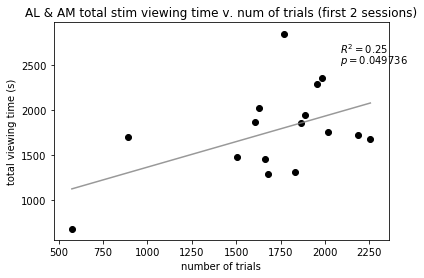

In [148]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # looking at first two sessions of stim B
    x.append(len(stimB_raw_RTs[animal][0]) + len(stimB_raw_RTs[animal][1]))
    y.append(stimB_raw_RTs_sum[animal][0] + stimB_raw_RTs_sum[animal][1])
    
y = [i*.001 for i in y] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of trials')
plt.ylabel('total viewing time (s)')
plt.title('AL & AM total stim viewing time v. num of trials (first 2 sessions)')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_v_num_trials_first2sesh_stimpair2.pdf')

treating correct trial stim viewing time as 2500 ms

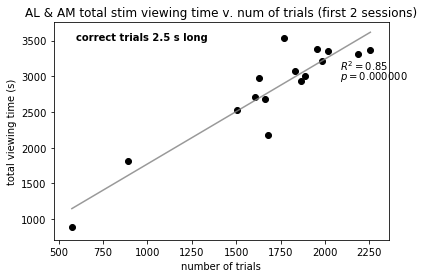

In [191]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # looking at first two sessions of stim B
    x.append(len(stimB_raw_RTs[animal][0]) + len(stimB_raw_RTs[animal][1]))
    y.append(stimB_raw_success2500_failure_RTs_sum[animal][0] + stimB_raw_success2500_failure_RTs_sum[animal][1])
    
y = [i*.001 for i in y] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.8*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of trials')
plt.ylabel('total viewing time (s)')
plt.title('AL & AM total stim viewing time v. num of trials (first 2 sessions)')
plt.text(600, 3500, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_success2500ms_v_num_trials_first2sesh_stimpair2.pdf')

### correlation between mean RT and total viewing time

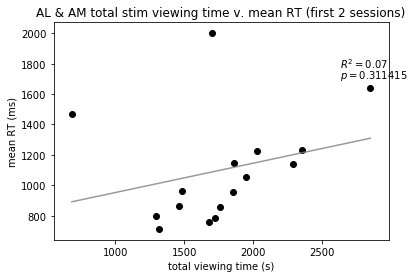

In [360]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # choose sessions to count
    sessions_to_count = 2
    x_sum = 0
    for i in range(sessions_to_count):
        x_sum += stimB_raw_RTs_sum[animal][i]
#         x_sum += stimB_raw_success2500_failure_RTs_sum[animal][i]
    x.append(x_sum)
    # average RT means from number of sessions to count
    y.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
    
x = [i*.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.8*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time (s)')
plt.ylabel('mean RT (ms)')
plt.title('AL & AM total stim viewing time v. mean RT (first 2 sessions)')
# plt.text(600, 3500, 'correct trials 2.5 s long', fontweight = 'bold' )
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_success2500ms_v_num_trials_first2sesh_stimpair2.pdf')

treating correct trial stim viewing time as 2500 ms

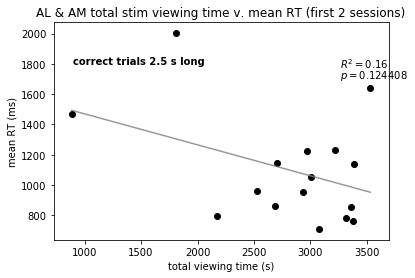

In [359]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # choose sessions to count
    sessions_to_count = 2
    x_sum = 0
    for i in range(sessions_to_count):
#         x_sum += stimB_raw_RTs_sum[animal][i]
        x_sum += stimB_raw_success2500_failure_RTs_sum[animal][i]
    x.append(x_sum)
    # average RT means from number of sessions to count
    y.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
    
x = [i*.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.8*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time (s)')
plt.ylabel('mean RT (ms)')
plt.title('AL & AM total stim viewing time v. mean RT (first 2 sessions)')
plt.text(900, 1800, 'correct trials 2.5 s long', fontweight = 'bold' )
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_success2500ms_v_num_trials_first2sesh_stimpair2.pdf')

### correlation between mean RT and number of trials

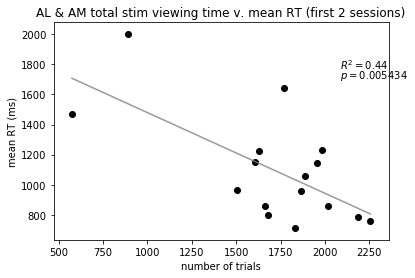

In [369]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # choose sessions to count
    sessions_to_count = 2
    x_sum = 0
    for i in range(sessions_to_count):
#         x_sum += stimB_raw_RTs_sum[animal][i]
#         x_sum += stimB_raw_success2500_failure_RTs_sum[animal][i]
        x_sum += len(stimB_raw_RTs[animal][i])
    x.append(x_sum)
    # average RT means from number of sessions to count
    y.append(np.mean(stimB_RTs[animal][:sessions_to_count]))
    
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.8*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of trials')
plt.ylabel('mean RT (ms)')
plt.title('AL & AM total stim viewing time v. mean RT (first 2 sessions)')
# plt.text(600, 3500, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_meanRT_v_num_trials_first2sesh_stimpair2.pdf')

### correlation between learning speed and total viewing time

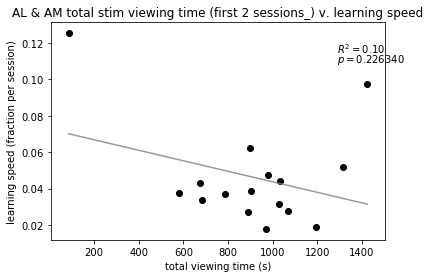

In [252]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first two sessions of stim B
        x_sum = 0
        for i in range(1):
            x_sum += stimB_raw_RTs_sum[animal][i]
    #     x.append(stimB_raw_RTs_sum[animal][0] + stimB_raw_RTs_sum[animal][1])
        x.append(x_sum)
        # learning speed till asymptitic performance
        y.append(stimB_learningspeed[animal]['slope'])
    
    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time (s)')
plt.ylabel('learning speed (fraction per session)')
plt.title('AL & AM total stim viewing time (first 2 sessions) v. learning speed')
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_first2sesh_v_learningspeed_stimpair2.pdf')

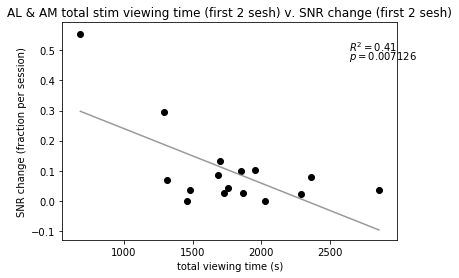

In [282]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first two sessions of stim B
        x_sum = 0
        for i in range(2):
            x_sum += stimB_raw_RTs_sum[animal][i]
    #     x.append(stimB_raw_RTs_sum[animal][0] + stimB_raw_RTs_sum[animal][1])
        x.append(x_sum)
        # learning speed till asymptitic performance
        y.append(stimB_Abar_learningspeed[animal]['slope'])
    
    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time (s)')
plt.ylabel('SNR change (fraction per session)')
plt.title('AL & AM total stim viewing time (first 2 sesh) v. SNR change (first 2 sesh)')
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_first13sesh_v_SNRchange_first13sesh_stimpair2.pdf')

treating correct trial stim viewing time as 2500 ms

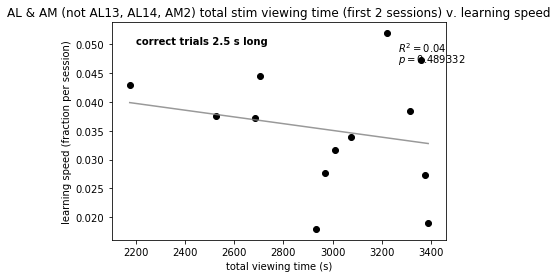

In [281]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
#     if animal not in ['hello']:
        # looking at certain number of sessions of stim B
        x_sum = 0
        for i in range(2):
            x_sum += stimB_raw_success2500_failure_RTs_sum[animal][i]
        x.append(x_sum)
        # learning speed till asymptitic performance
        y.append(stimB_learningspeed[animal]['slope'])
     
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time (s)')
plt.ylabel('learning speed (fraction per session)')
# plt.text(800, 0.11, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.text(2200, 0.05, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.title('AL & AM (not AL13, AL14, AM2) total stim viewing time (first 2 sessions) v. learning speed')
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_except_AL13_AL14_AM2_total_stim_viewing_time_success2500ms_first2sesh_v_learningspeed_stimpair2.pdf')

#### correlation between SNR change and total viewing time

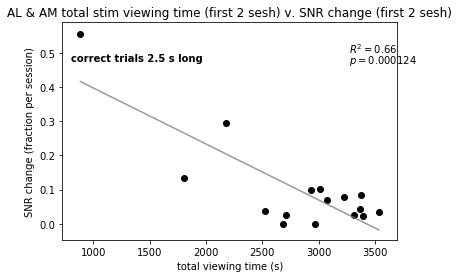

In [287]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at certain number of sessions of stim B
        x_sum = 0
        for i in range(2):
            x_sum += stimB_raw_success2500_failure_RTs_sum[animal][i]
        x.append(x_sum)
        # learning speed till asymptitic performance
#         y.append(stimB_learningspeed[animal]['slope'])
        y.append(stimB_Abar_learningspeed[animal]['slope'])
    
    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time (s)')
plt.ylabel('SNR change (fraction per session)')
# plt.text(800, 0.11, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.text(800, 0.475, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.title('AL & AM total stim viewing time (first 2 sesh) v. SNR change (first 2 sesh)')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_success2500ms_first2sesh_v_SNRchange_first2sesh_stimpair2.pdf')

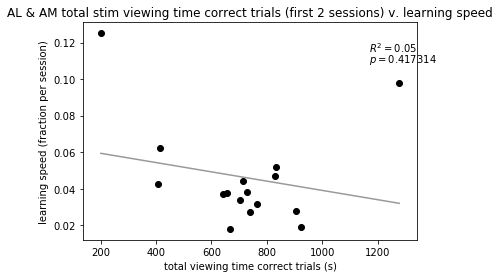

In [151]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # looking at first two sessions of stim B
    x.append(stimB_raw_success_RTs_sum[animal][0] + stimB_raw_success_RTs_sum[animal][1])
    # learning speed till asymptitic performance
    y.append(stimB_learningspeed[animal]['slope'])
    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time correct trials (s)')
plt.ylabel('learning speed (fraction per session)')
plt.title('AL & AM total stim viewing time correct trials (first 2 sessions) v. learning speed')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_correctrials_first2sesh_v_learningspeed_stimpair2.pdf')

#### correlation between SNR change and total viewing time correct trials

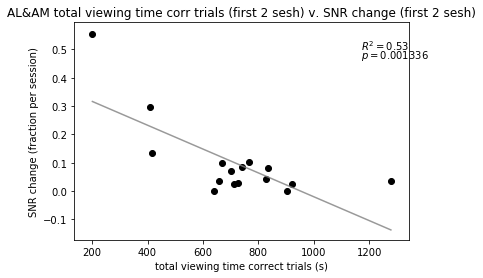

In [294]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first x sessions of stim B
        x_sum = 0
        for i in range(2):
            x_sum += stimB_raw_success_RTs_sum[animal][i]
        x.append(x_sum)
        # SNR change 
        y.append(stimB_Abar_learningspeed[animal]['slope'])
    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time correct trials (s)')
plt.ylabel('SNR change (fraction per session)')
plt.title('AL&AM total viewing time corr trials (first 2 sesh) v. SNR change (first 2 sesh)')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_correctrials_first2sesh_v_SNRchange_first2sesh_stimpair2.pdf')

treating correct trial stim viewing time as 2500 ms

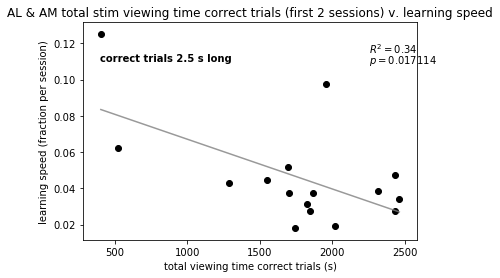

In [207]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first two sessions of stim B
        x.append(stimB_raw_success2500_RTs_sum[animal][0] + stimB_raw_success2500_RTs_sum[animal][1])
        # learning speed till asymptitic performance
        y.append(stimB_learningspeed[animal]['slope'])
    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time correct trials (s)')
plt.ylabel('learning speed (fraction per session)')
plt.text(400, 0.11, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.title('AL & AM total stim viewing time correct trials (first 2 sessions) v. learning speed')
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_success2500ms_correctrials_first2sesh_v_learningspeed_stimpair2.pdf')

#### correlation between SNR change and total viewing time correct trials (2.5 s)

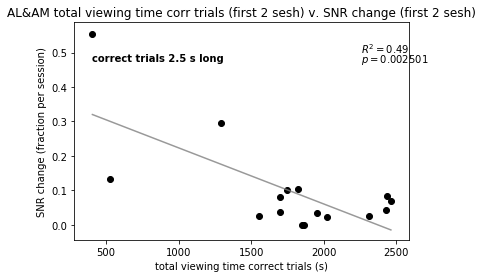

In [299]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first x sessions of stim B
        x_sum = 0
        for i in range(2):
            x_sum += stimB_raw_success2500_RTs_sum[animal][i]
        x.append(x_sum)
        # learning speed till asymptitic performance
        y.append(stimB_Abar_learningspeed[animal]['slope'])
    
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time correct trials (s)')
plt.ylabel('SNR change (fraction per session)')
plt.text(400, 0.475, 'correct trials 2.5 s long', fontweight = 'bold' )
plt.title('AL&AM total viewing time corr trials (first 2 sesh) v. SNR change (first 2 sesh)')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_success2500ms_correctrials_first2sesh_v_SNRchange_first2sesh_stimpair2.pdf')

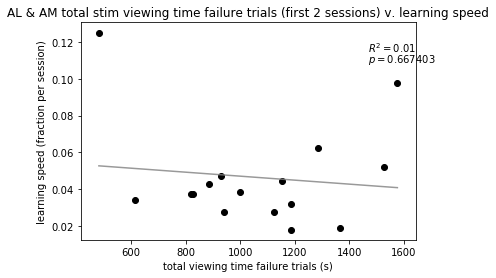

In [152]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # looking at first two sessions of stim B
    x.append(stimB_raw_failure_RTs_sum[animal][0] + stimB_raw_failure_RTs_sum[animal][1])
    # learning speed till asymptitic performance
    y.append(stimB_learningspeed[animal]['slope'])
     
x = [i*0.001 for i in x] # convert to seconds
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('total viewing time failure trials (s)')
plt.ylabel('learning speed (fraction per session)')
plt.title('AL & AM total stim viewing time failure trials (first 2 sessions) v. learning speed')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_total_stim_viewing_time_failuretrials_first2sesh_v_learningspeed_stimpair2.pdf')

#### correlation between learning speed and number of trials

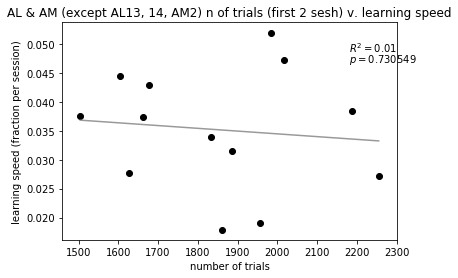

In [179]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
        # looking at first two sessions of stim B
        x.append(len(stimB_raw_RTs[animal][0]) + len(stimB_raw_RTs[animal][1]))
        # learning speed till asymptitic performance
        y.append(stimB_learningspeed[animal]['slope'])

    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of trials')
plt.ylabel('learning speed (fraction per session)')
plt.title('AL & AM (except AL13, 14, AM2) n of trials (first 2 sesh) v. learning speed')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_except_AL13_AL14_AM2_num_of_trials_first2sesh_v_learningspeed_stimpair2.pdf')

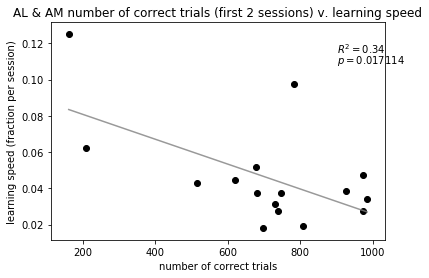

In [157]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # looking at first two sessions of stim B
    x.append(len(stimB_raw_success_RTs[animal][0]) + len(stimB_raw_success_RTs[animal][1]))
    # learning speed till asymptitic performance
    y.append(stimB_learningspeed[animal]['slope'])
    
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of correct trials')
plt.ylabel('learning speed (fraction per session)')
plt.title('AL & AM number of correct trials (first 2 sessions) v. learning speed')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_num_of_correct_trials_first2sesh_v_learningspeed_stimpair2.pdf')

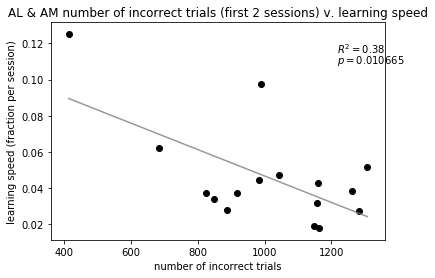

In [156]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
    # looking at first two sessions of stim B
    x.append(len(stimB_raw_failure_RTs[animal][0]) + len(stimB_raw_failure_RTs[animal][1]))
    # learning speed till asymptitic performance
    y.append(stimB_learningspeed[animal]['slope'])
    
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of incorrect trials')
plt.ylabel('learning speed (fraction per session)')
plt.title('AL & AM number of incorrect trials (first 2 sessions) v. learning speed')
plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_num_of_failure_trials_first2sesh_v_learningspeed_stimpair2.pdf')

#### correlation between SNR change and number of trials

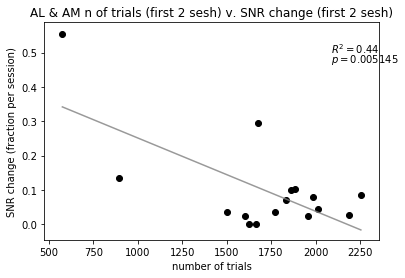

In [366]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first few sessions of stimB
        x_sum = 0
        for i in range(2):
            x_sum += len(stimB_raw_RTs[animal][i])
        x.append(x_sum)
        # SNR change for first 2 sessions
        y.append(stimB_Abar_learningspeed[animal]['slope'])

    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of trials')
plt.ylabel('SNR change (fraction per session)')
plt.title('AL & AM n of trials (first 2 sesh) v. SNR change (first 2 sesh)')
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_except_AL13_AL14_AM2_num_of_trials_first2sesh_v_learningspeed_stimpair2.pdf')

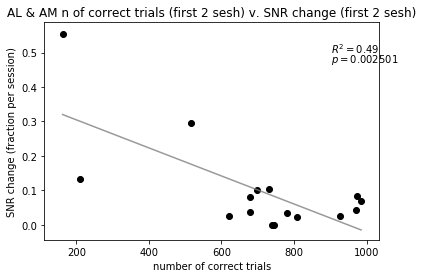

In [367]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first few sessions of stimB
        x_sum = 0
        for i in range(2):
            x_sum += len(stimB_raw_success_RTs[animal][i])
        x.append(x_sum)
        # SNR change for first 2 sessions
        y.append(stimB_Abar_learningspeed[animal]['slope'])

    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of correct trials')
plt.ylabel('SNR change (fraction per session)')
plt.title('AL & AM n of correct trials (first 2 sesh) v. SNR change (first 2 sesh)')
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_except_AL13_AL14_AM2_num_of_trials_first2sesh_v_learningspeed_stimpair2.pdf')

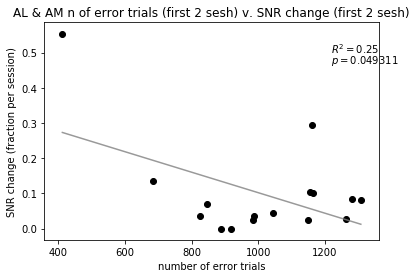

In [368]:
x = []
y = []
for animal in stimB_raw_RTs.keys():
#     if animal not in ['AL13', 'AL14', 'AM2']: # fastest learners, remove to check if correlation still holds
    if animal not in ['hello']:
        # looking at first few sessions of stimB
        x_sum = 0
        for i in range(2):
            x_sum += len(stimB_raw_failure_RTs[animal][i])
        x.append(x_sum)
        # SNR change for first 2 sessions
        y.append(stimB_Abar_learningspeed[animal]['slope'])

    
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# make line of best fit ('lobf')
x_of_lobf = [min(x), max(x)]
y_of_lobf = [slope*xx + intercept for xx in x_of_lobf]

# coefficient of determination, plot text
# variance = np.var(y)
# residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x,y)])
# Rsqr = np.round(1-residuals/variance, decimals=2)
Rsqr = r_value**2

# plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.9*max(y)+.1*min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=10)
plt.text(.9*max(x)+.1*min(x),.85*max(y)+.15*min(y),'$p = %0.6f$'% p_value, fontsize=10)

# plt.text(.9*max(x)+.1*min(x), .85*max(y)+.1*min(y), 'y = %0.2fx + %0.2f' %(slope, intercept))

# plt.plot(perf_diff, learningspeed, 'ko')
# plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)

plt.plot(x_of_lobf, y_of_lobf, '-', color = 'gray', alpha = 0.8)    
    
plt.scatter(x, y, color = 'k')
plt.xlabel('number of error trials')
plt.ylabel('SNR change (fraction per session)')
plt.title('AL & AM n of error trials (first 2 sesh) v. SNR change (first 2 sesh)')
# plt.savefig('_graphs_stimpair2/total_viewing_time/AL_AM_except_AL13_AL14_AM2_num_of_trials_first2sesh_v_learningspeed_stimpair2.pdf')